**Questão de negócio**: previsão de venda das próximas 6 semanas

**Entendimento do Negócio:** CFO precisa saber quanto cada loja vai gerar de lucro
pra poder investir a grana correta

# 0.0 Imports

In [149]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pickle #formato utilizado para guardar modelos

from boruta import BorutaPy

from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

from flask import Flask, request, Response

from IPython.core.display import HTML
import datetime
from IPython.display import Image



## 0.1 Helper functions

In [2]:
#função para melhorar a exibição dos gráficos

def jupyter_settings():
  %matplotlib inline
  %pylab inline
  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [25, 12]
  plt.rcParams['font.size'] = 24
  display( HTML( '<style>.container { width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )
  sns.set()
    

#função para calculo dos erros
def ml_error(model_name, y, yhat ):
    mae  = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat) )
    
    #criação do dataframe para armazenar as variáveis
    return pd.DataFrame ({'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse},
                          index =[0]
                         )
    

#estrutura das datas para aplicação da time series cross validation
#delta do validation: 6 semanas
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list =  []
    mape_list = []
    rmse_list = []
    
    for k in reversed ( range(1, kfold + 1) ):
        if verbose:
            print('\nKFoldNumber: {}'.format(k))
        #validation: start and end
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date =   x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)  

        #training 
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        #training and validation dataset
        xtraining = training.drop(['sales', 'date'], axis = 1)
        ytraining = training['sales']


        xvalidation = validation.drop(['sales', 'date'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat) )
        
        #store performance of each kfold interaction
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame( 
                        {'Model Name': model_name,
                         'MAE CV':  np.round(np.mean(mae_list),2).astype(str) + 
                          ' +/- ' + np.round( np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + 
                          ' +/- ' + np.round( np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) +
                         ' +/- ' + np.round( np.std(rmse_list), 2).astype(str)}, index=[0] 
    
                         )
   
    
    
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
        

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
df_sales_raw = pd.read_csv( 'train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'store.csv', low_memory=False )
# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 Descrição dos Dados

In [5]:
df1 = df_raw.copy()

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
'Promo', 'StateHoliday', 'SchoolHoliday',
'StoreType', 'Assortment', 'CompetitionDistance',
'CompetitionOpenSinceMonth',
'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore( x )
cols_new = list( map( snakecase, cols_old ) )
# rename
df1.columns = cols_new

In [7]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [10]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
31389,170,5,2015-07-03,4852,494,1,1,0,1,a,a,1070.0,5.0,2015.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


## Formas de tratar um NA:
-1: Excluindo os NA's, porém eu perco dados.

-2: Algoritmos de machine learning que vão entender o comportamento da coluna.

-3: Pensando no negócio: 

In [11]:
#df1['competition_distance'] sem NA's
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA


In [12]:
#Abaixo segue todas as colunas que possuem os NA que precisam ser tratados

#1-competition_distance              
#2-competition_open_since_month    
#3-competition_open_since_year                                   
#4-promo2_since_week               
#5-promo2_since_year               
#6-promo_interval                  

In [13]:
#1-competition_distance  
# - Ou não tem competidor perto, ou está tão longe que considera que não tenha. 

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000 if math.isnan(x)  else x)

In [14]:
#2-competition_open_since_month

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                                 else x['competition_open_since_month'], axis=1 )

In [15]:
#3-competition_open_since_year

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )
                                                else x['competition_open_since_year'], axis=1 )


In [16]:
#4-promo2_since_week 

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week'] ) 
                                     else x['promo2_since_week'], axis=1 )

In [17]:
#5-promo2_since_year

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year'] ) 
                                     else x['promo2_since_year'], axis=1 )

In [18]:
#6- promo_interval
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
786151,862,6,2013-07-27,5899,764,1,0,0,0,a,c,2840.0,3.0,2010.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


In [19]:
df1['promo_interval'].fillna(0, inplace=True )
df1['promo_interval'].head()

0                  0
1    Jan,Apr,Jul,Oct
2    Jan,Apr,Jul,Oct
3                  0
4                  0
Name: promo_interval, dtype: object

In [20]:
#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [21]:
#criação da month map
# .map: retira o valor da chave
df1['month_map'] = df1['date'].dt.month.map( month_map )

In [22]:
df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 
                                                             else 1 if x['month_map'] in x['promo_interval'].split( ',' ) 
                                                             else 0, axis=1 )

## 1.7 Estatistica Descritiva

- Precisamos separar as variáveis numéricas e as variáveis categóricas

- Skew: se refere as caudas da curva

- Kurtosis: se refere ao achatamento da curva 


In [23]:
#dataframe com os atributos numéricos
num_attributes = df1.select_dtypes( include= ['int64', 'float64'])
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9.0,2008.0,0,31.0,2015.0,0
1,2,5,6064,625,1,1,1,570.0,11.0,2007.0,1,13.0,2010.0,1
2,3,5,8314,821,1,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,1
3,4,5,13995,1498,1,1,1,620.0,9.0,2009.0,0,31.0,2015.0,0
4,5,5,4822,559,1,1,1,29910.0,4.0,2015.0,0,31.0,2015.0,0


In [24]:
cat_attributes = df1.select_dtypes( exclude= ['int64', 'float64', 'datetime64[ns]'])
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


### 1.7.1 Atributos Numéricos

In [25]:
# Tendência central: Média e Mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T

ct2 = pd.DataFrame(num_attributes.apply(np.median) ).T

In [26]:
# Dispersão: std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min ) ).T
d3 = pd.DataFrame(num_attributes.apply(max ) ).T
#Para fazer o range: max - min
## como eu preciso fazer uma função que passar por todos os items do dataframe
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew() )).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() )).T


#### Estatísticas de 1º ordem


In [27]:
#concatenando

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std',
             'skew', 'kurtosis']

In [28]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

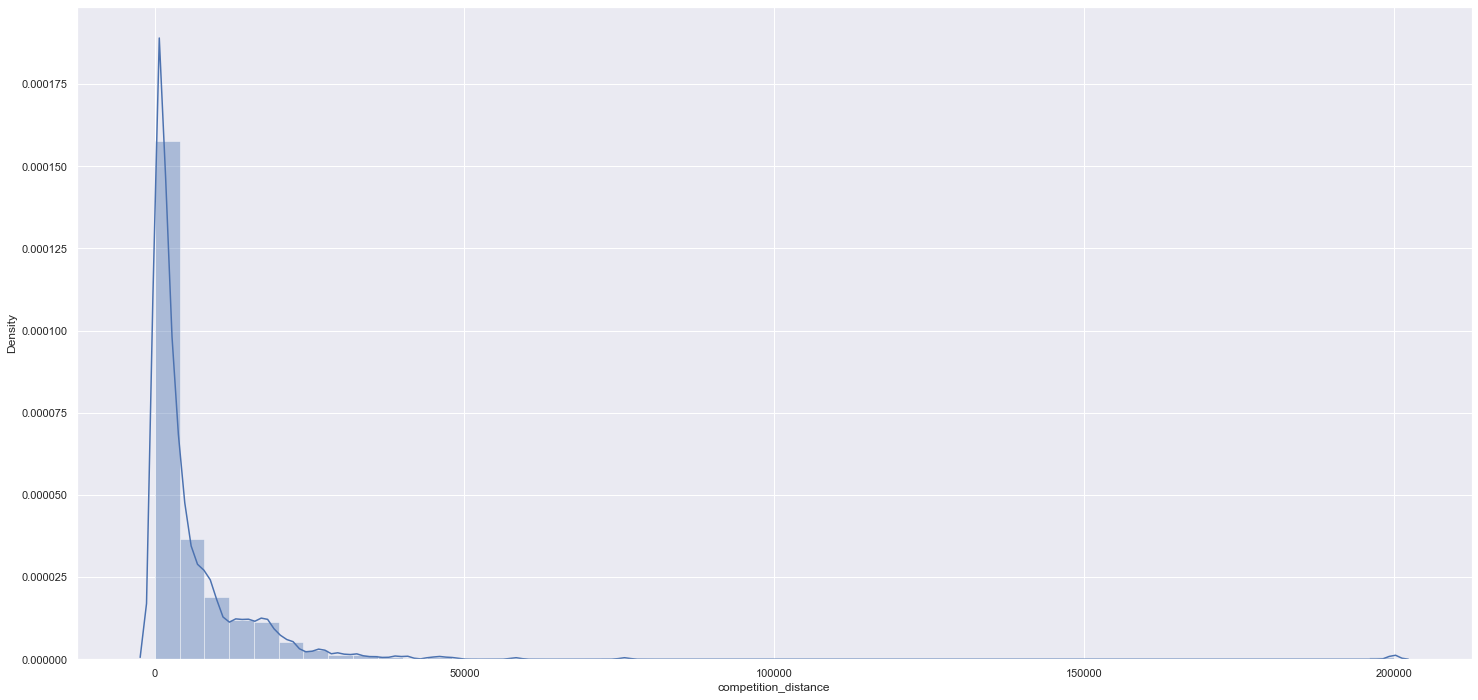

In [29]:
#exemplo: competition distance
sns.distplot( df1['competition_distance'])

### 1.7.2 Atributos Categóricos

In [30]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

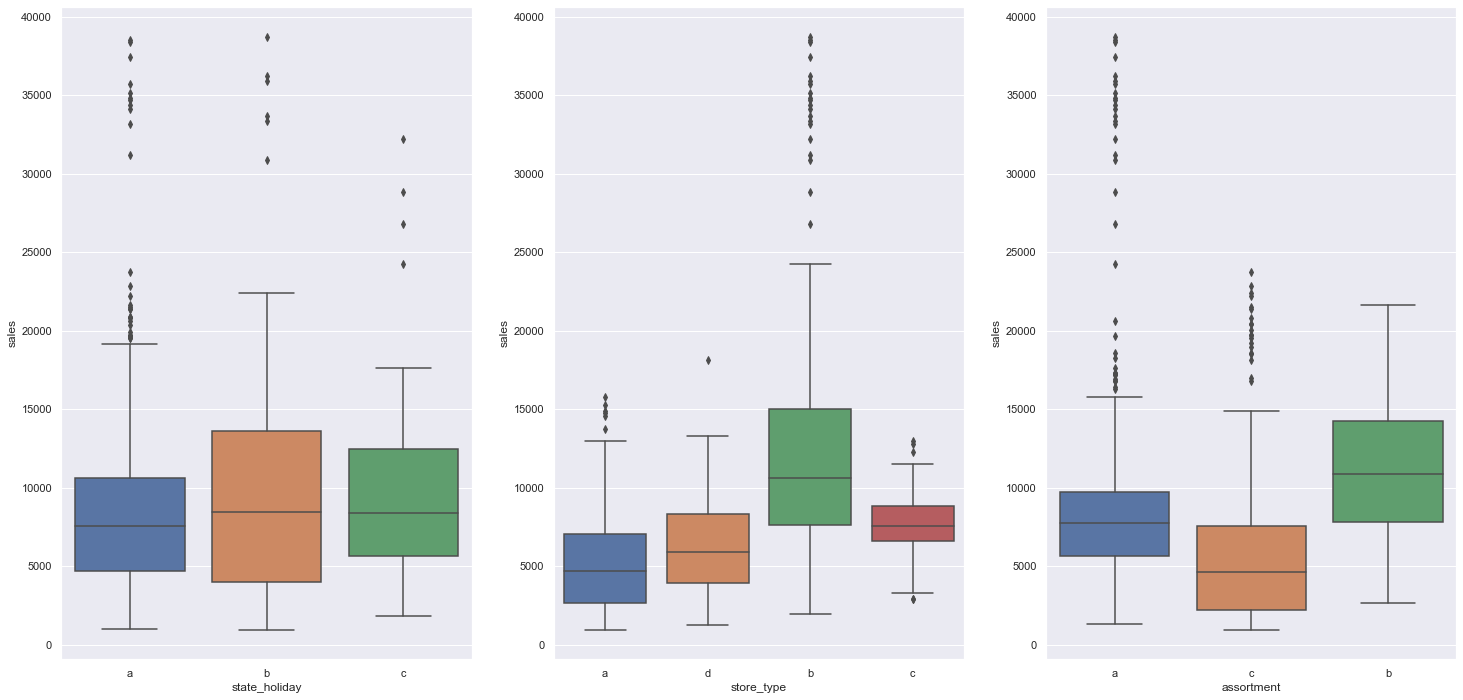

In [31]:
#Boxplot das variáveis categóricas

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

#indice do subplot
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 Feature Engineering



## Mapa Mental de Hipóteses
  Fenômeno: qual fenômeno estou modelando ?

  Agentes: quem são os agentes que atuam sobre o fenômeno de interesse ?

  Atributos dos agentes: qual a descrição dos agentes ?

  Lista de Hipóteses: cada hipótese validada ou descartada, é o famoso insight

In [32]:
from IPython.display import Image

## Hipóteses são Apostas.

- Lojas de MAIOR porte, deveriam vender MAIS.
-- Porte é um atributo do agente loja.
-- Vender é a minha variável resposta do fenômeno que estou tentando modelar, as vendas das lojas

## 2.1 Criação das Hipóteses

### 2.1.1 Hipoteses Loja

### 2.1.2 Hipoteses Produto

### 2.1.3 Hipoteses Tempo

### 2.1.4 Change Data types

In [33]:
df2 = df1.copy()

In [34]:
# preciso converter para a int, pois o datetime estava tendo problemas com o float

# competition_open_since
df2['competition_open_since_month'] = df2['competition_open_since_month'].astype(int)
df2['competition_open_since_year'] = df2['competition_open_since_year'].astype(int)

# promo2
df2['promo2_since_week'] = df2['promo2_since_week'].astype( int )
df2['promo2_since_year'] = df2['promo2_since_year'].astype( int )

In [35]:
df2.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 2.4 Feature Engineering

###  - Criação das features a partir dos dados que temos

In [36]:
########### Dates Features ########################

# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

########### Others Features ######################

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                  month=x['competition_open_since_month'], day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
## data atual - o inicio da promoção
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )

 
# assortment
## trocando os simbolos de cada assortment para os nomes
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' 
                                            else 'extra' if x == 'b' 
                                            else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' 
                                                  else 'easter_holiday' if x == 'b' 
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day' )

C:\Users\Will\AppData\Local\Temp/ipykernel_13400/3931064040.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 Filtragem das variáveis

In [37]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

### - Como vendas é a variável resposta, filtro tudo aonde não ocorrem as vendas.

In [38]:
#relação direta: se a loja não abre, tenho venda 0
df3 = df3[(df3['open'] != 0 ) & (df3['sales'] > 0)]
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.2 Seleção das Colunas

In [39]:
#não tenho as informações dos clientes depois das 6 semanas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop ( cols_drop, axis = 1)

# 4.0 Análise Exploratória dos Dados (EDA)

Quais os 3 objetivos da EDA ?
- Ganhar experiência no negócio
- Validar Hipóteses de Negócio ( Insight's)
- Perceber variáveis que são importantes para o modelo 

In [40]:
df4 = df3.copy()

## 4.1 Análise Univariada

- Como é essa varíavel (Min, Max, Distribuição, Range,...)

### 4.1.1 Response Variable

D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


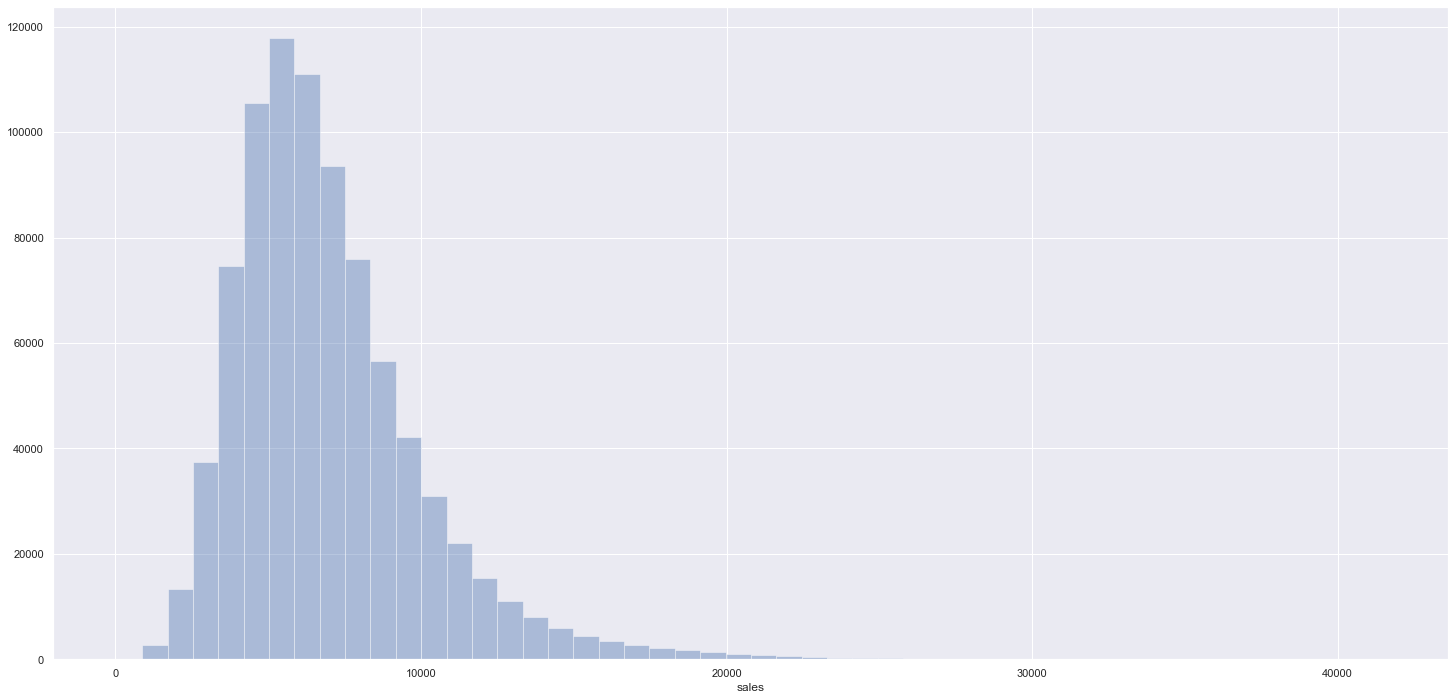

In [41]:
sns.distplot( df4['sales'], kde=False );

### 4.1.2 Numerical Variable

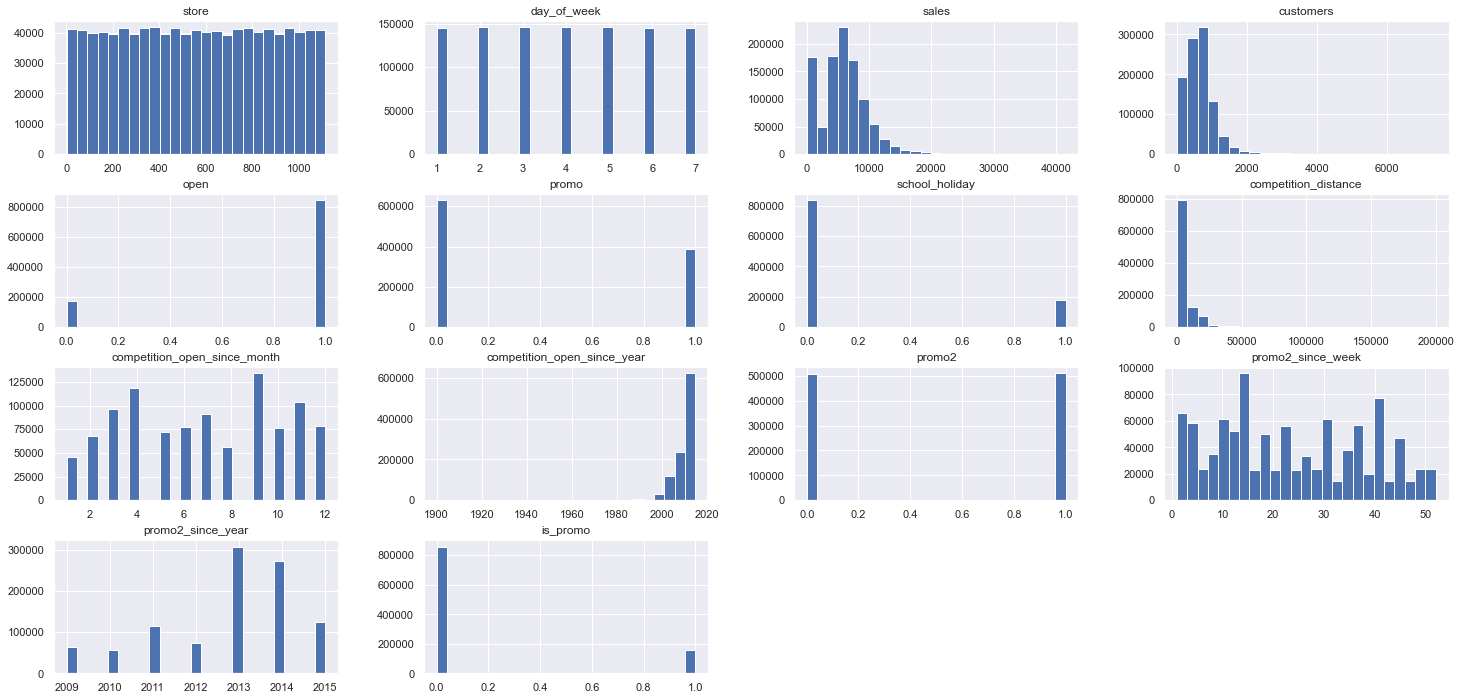

In [42]:
num_attributes.hist(bins = 25);

In [43]:
# usamos o drop_duplicates e não o value_counts, para não repetir os dias
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='state_holiday', ylabel='count'>

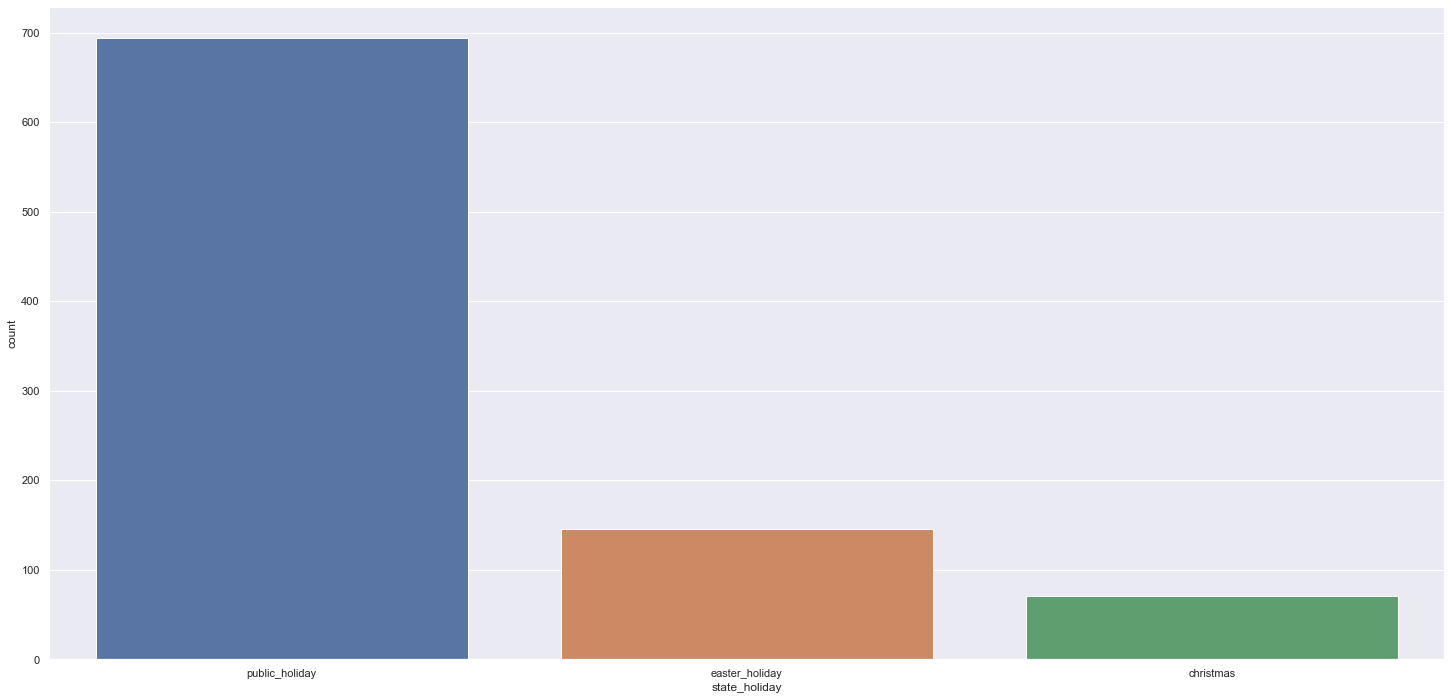

In [44]:
#retirando o regular_day do state_holiday
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot(a['state_holiday'])

Gráfico para plotar a quantidade de variáveis de uma coluna: sns.countplot()

### 4.1.3 Categorical Variable

D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

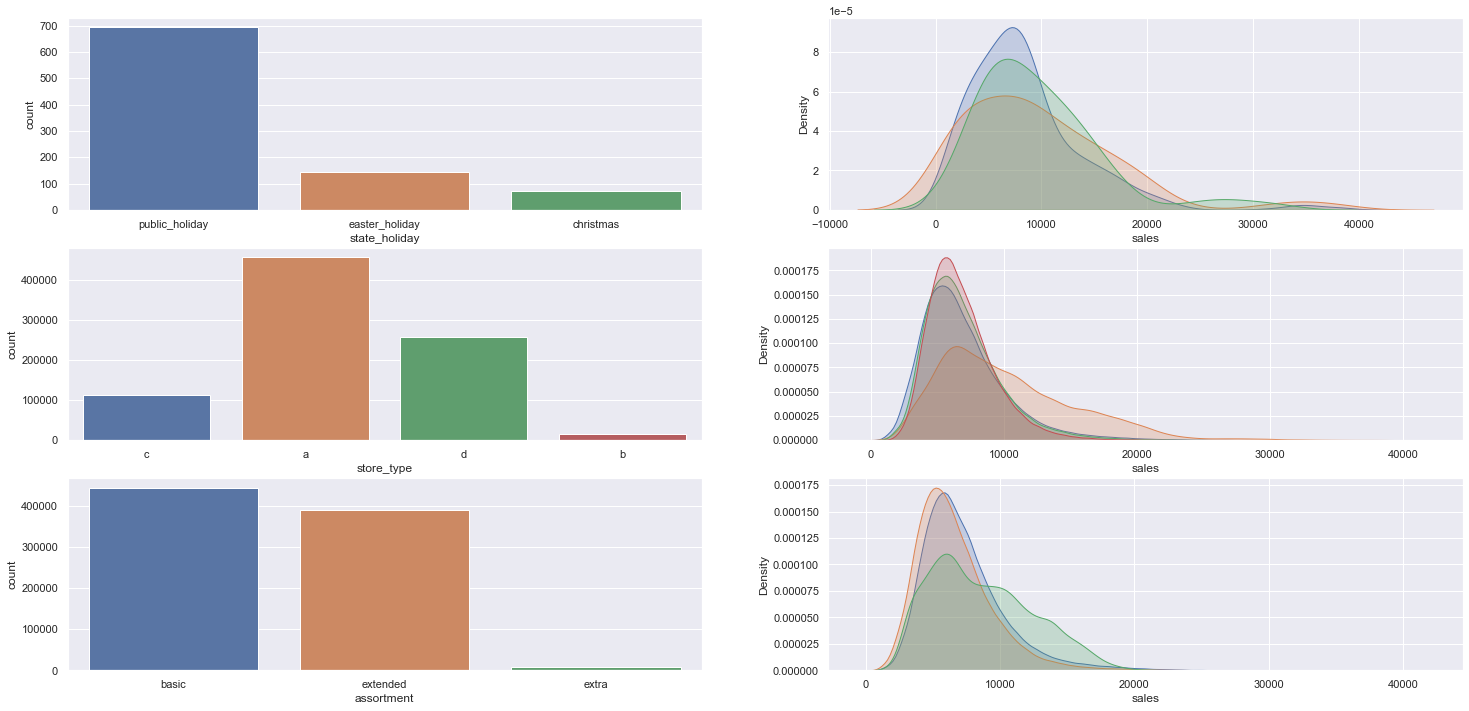

In [45]:
# state_holiday
## tirando o regular day porque tem muitos, para mostrar os outros no gráfico
plt.subplot( 3, 2, 1 )
a = df4[df4['state_holiday'] != 'regular_day']
# como se fosse um value counts, aonde só preciso por a coluna que eu quero
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'],
label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'],
label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'],
label='christmas', shade=True )

# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
# uma coluna do dataframe é equivalente a uma pandas.series
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended',
shade=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic',
shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra',
shade=True )

In [46]:
type(df4[df4['store_type'] == 'a']['sales'])

pandas.core.series.Series

## 4.2 Análise Bivariada
- Como a variável impacta na resposta ?
(correlação, validação das hipóteses,..)

In [47]:
df4[['store', 'sales', 'assortment']].groupby(['store', 'assortment'] ).sum().sort_values(by = 'sales', ascending = False).head()

,,sales
store,assortment,
262,basic,19516842
817,basic,17057867
562,extended,16927322
1114,extended,16202585
251,extended,14896870


### H1. Lojas com maior sortimentos deveriam vender mais.

FALSA Lojas com MAIOR SORTIMENTO vendem MENOS.



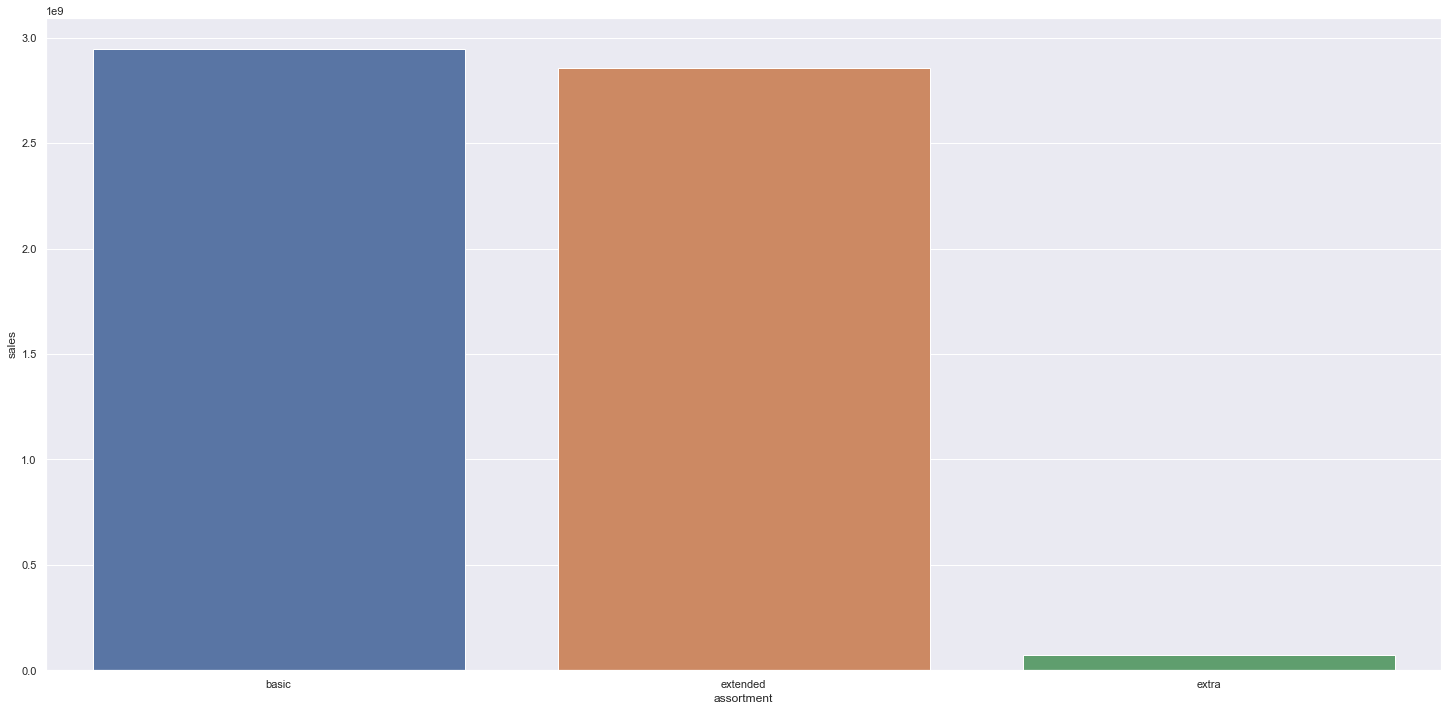

In [48]:
# mostrando que lojas com sortimentos basicos tem mais vendas que lojas com sortiments extended's
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

In [49]:
# dataframe organizado com as linhas year_week, colunas com os tipos de assortment com as somatórias das vendas
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week','assortment'] ).sum().reset_index()
#pivot = reorganiza o dataframe de acordo com as linhas e colunas que colocar na função
aux3 = aux2.pivot( index='year_week', columns='assortment', values='sales' )
aux3.head()

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061


<AxesSubplot:xlabel='year_week'>

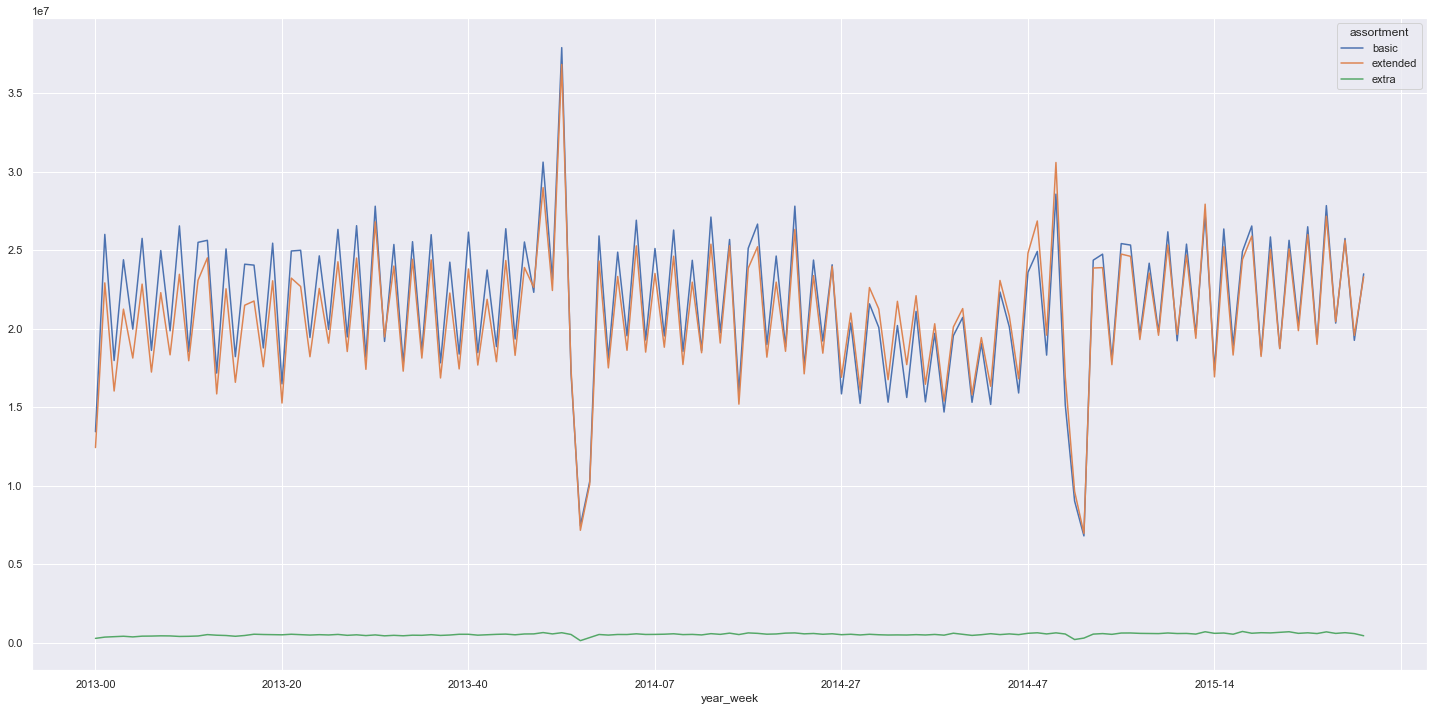

In [50]:
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

<AxesSubplot:xlabel='year_week'>

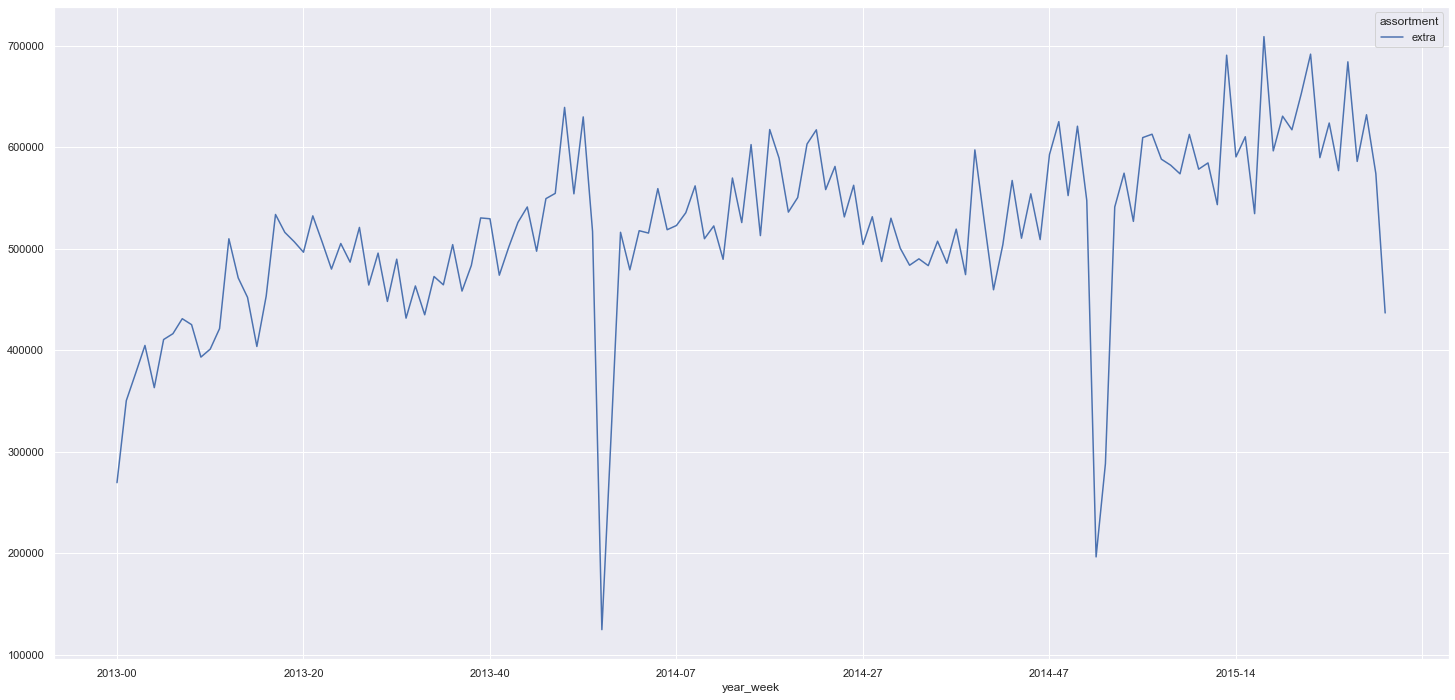

In [51]:
#verificando o comportamento apenas do extra, que no outro gráfico parece que é linear
## aux2['assortment'] == 'extra' pega só a condição booleana
## aux2[aux2[ pega todas as linhas e colunas

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
FALSA Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

#### .cut segmenta os meus valores em intervalos discretos

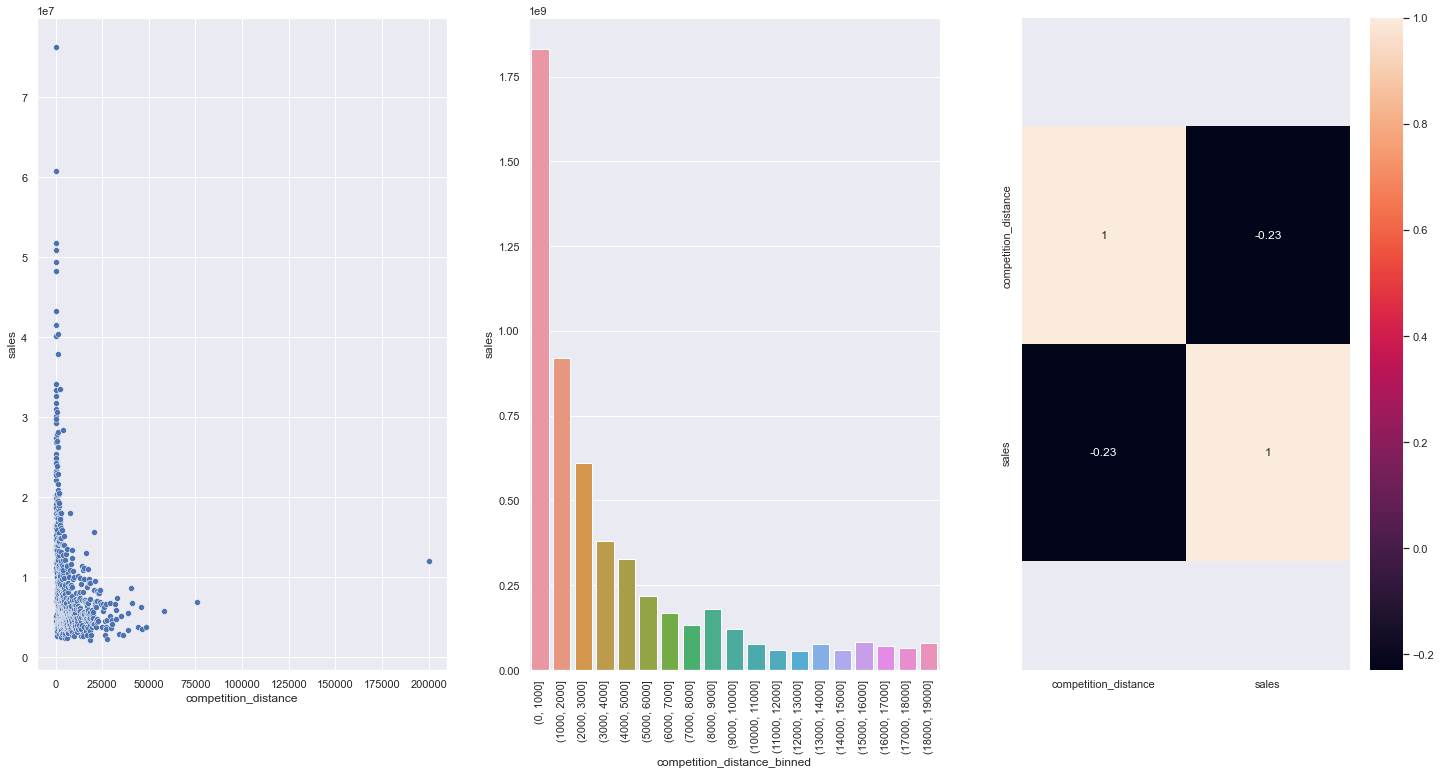

In [52]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.scatterplot( x ='competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
# criação de uma lista aonde eu posso organizar os valores
bins = list( np.arange( 0, 20000, 1000) )
# pd.cut: coloca a coluna selecionada dentro do bin que eu criei
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'],bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 );
# rotaciona os labels para não ficarem tudo junto
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson' ), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5 );

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
FALSE Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

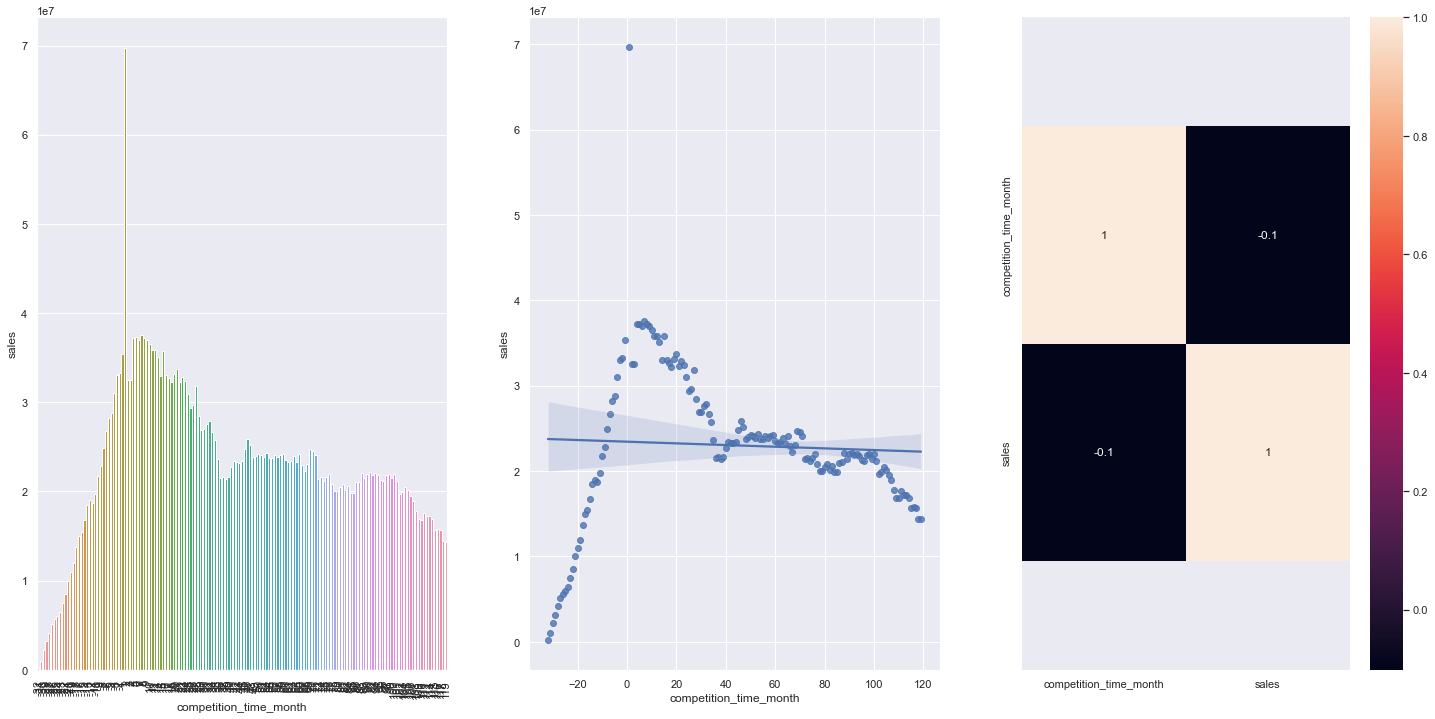

In [53]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
x = sns.heatmap( aux1.corr( method='pearson'), annot=True );
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
FALSA Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

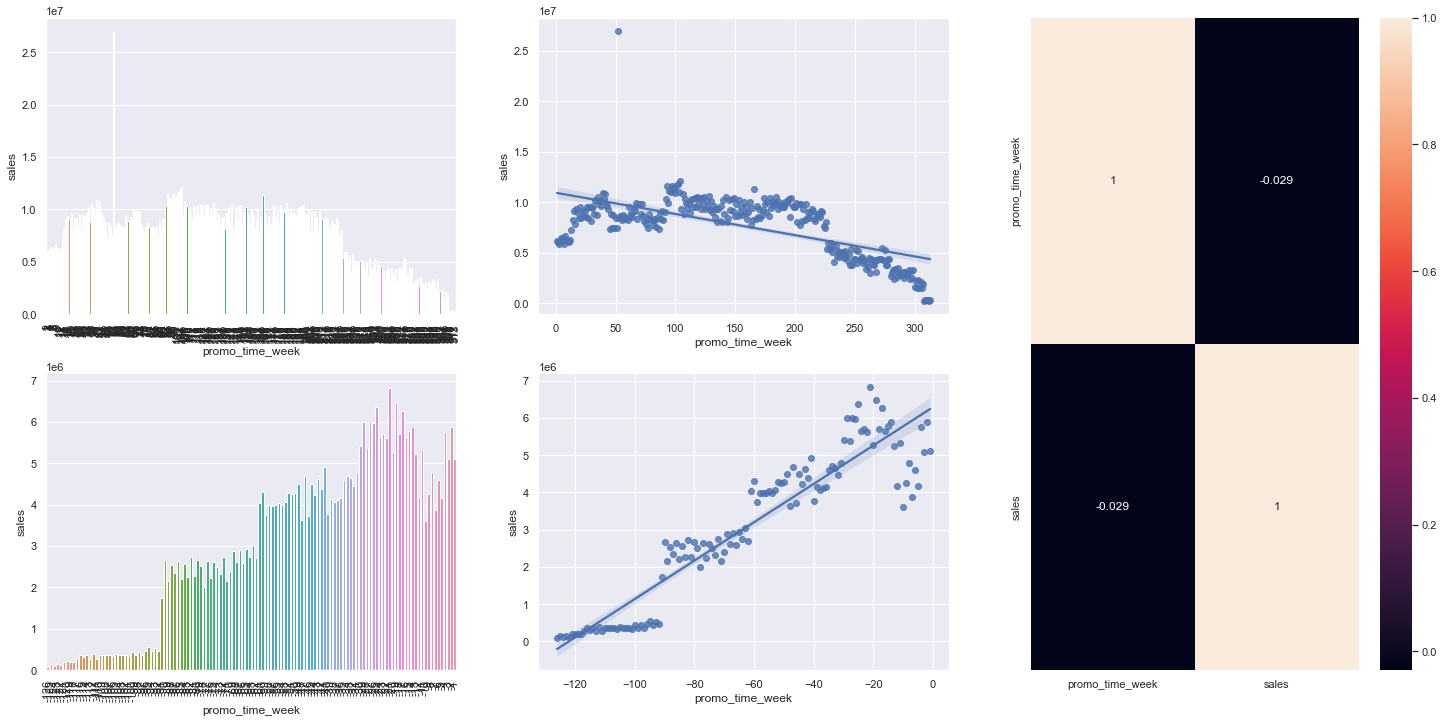

In [54]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3 )
plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

In [55]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


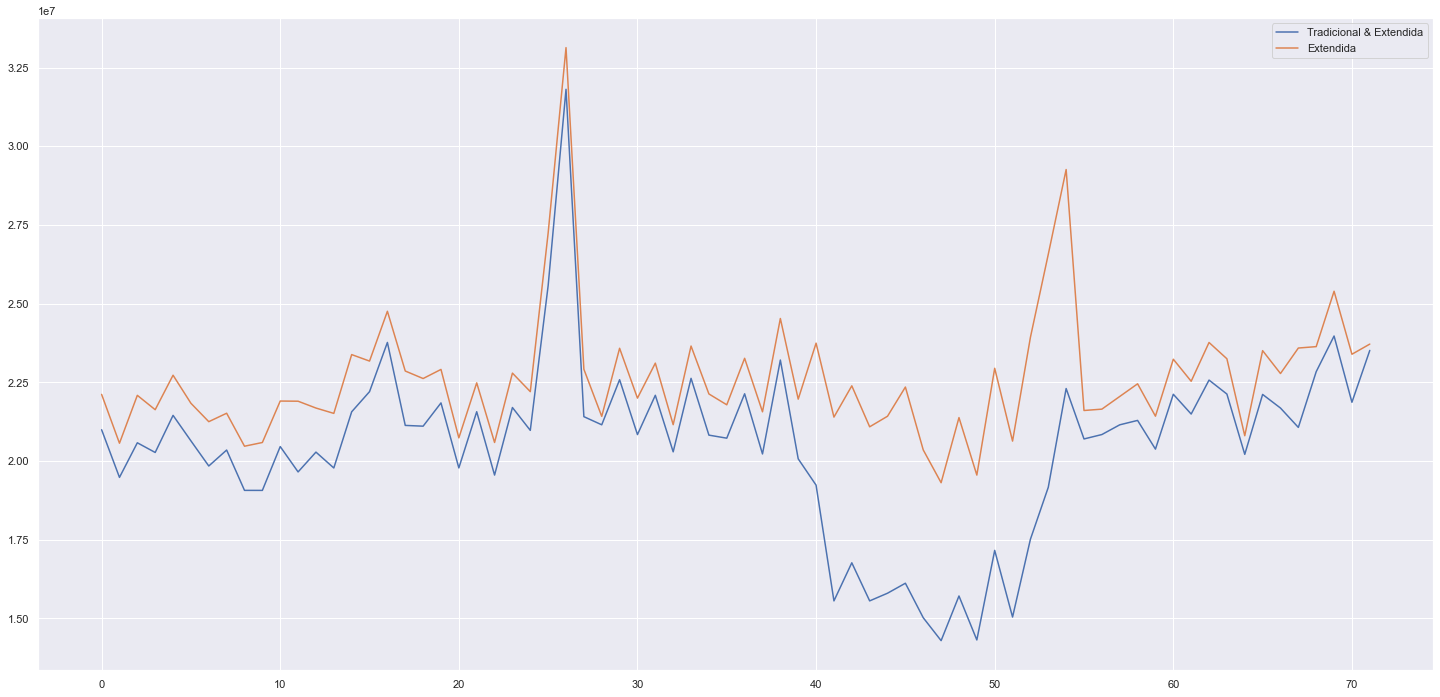

In [56]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA Lojas abertas durante o feriado do Natal vendem menos.

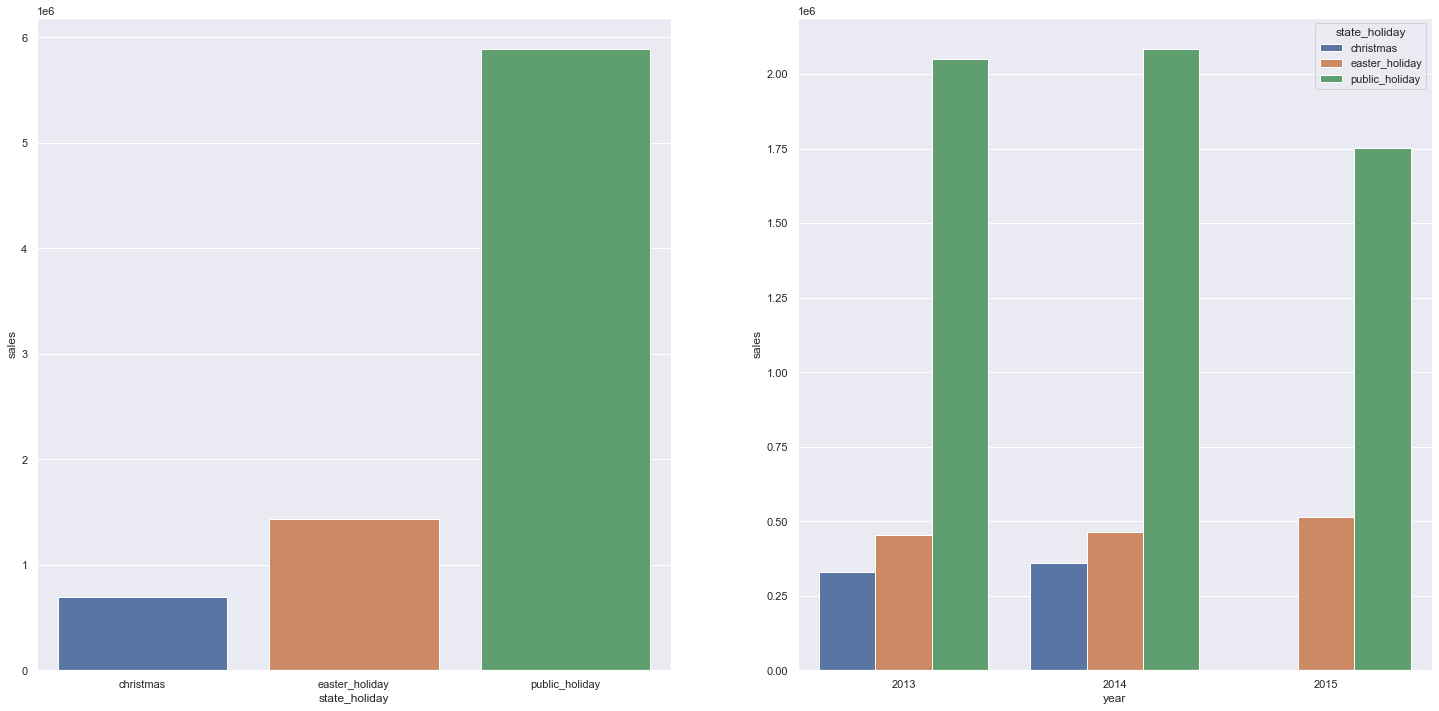

In [57]:
# filtrando os dias regulares
aux = df4[df4['state_holiday'] != 'regular_day']

#plotando apenas as vendas totais dos feriados
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

#plotando as vendas dos feriados por ano
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA Lojas vendem menos no segundo semestre do ano

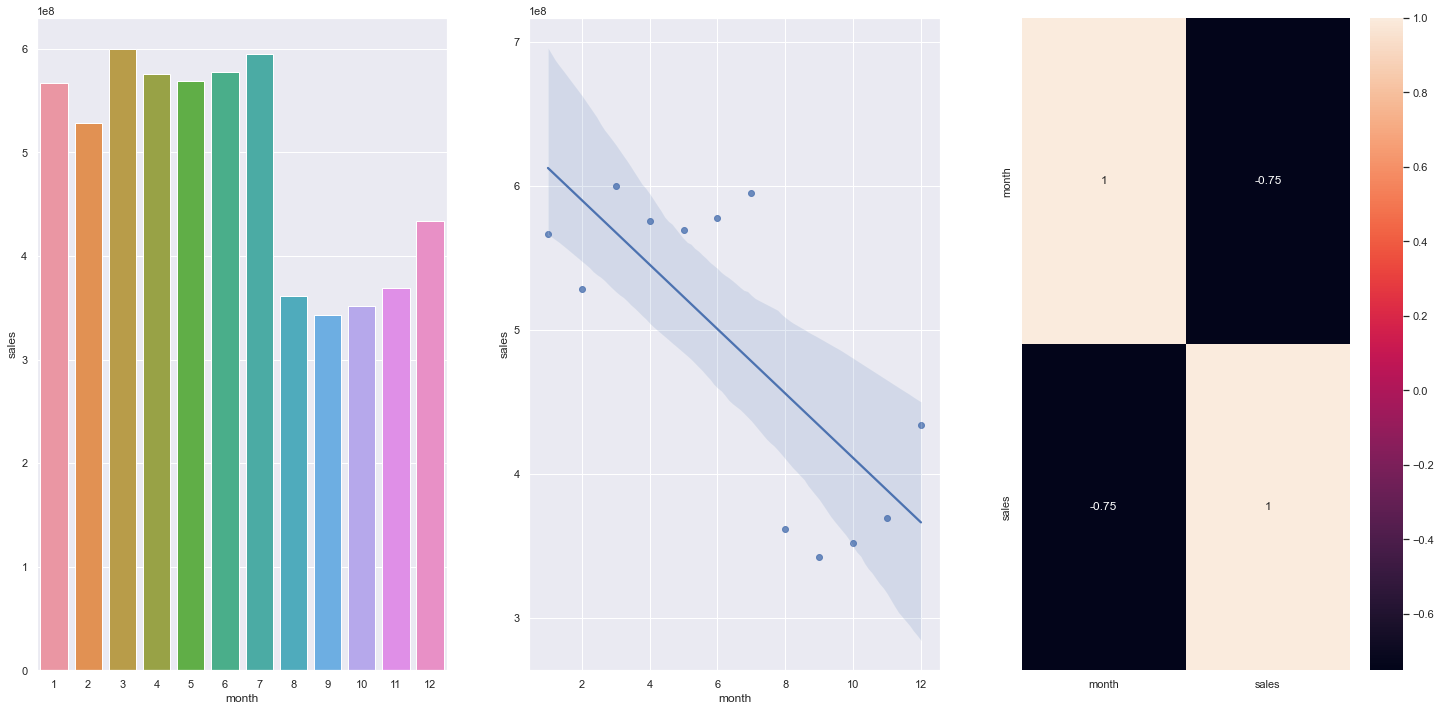

In [58]:
#criação do dataframe com as colunas da hipótese
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### Resumo da hipóteses

In [59]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [60]:
#criação de tabela: listas de listas
from tabulate import tabulate

In [61]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]

In [62]:
print( tabulate(tab, headers = 'firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Análise Multivariada
- Como as variáveis se relacionam ?

### 4.3.1 Numerical Attributes

<AxesSubplot:>

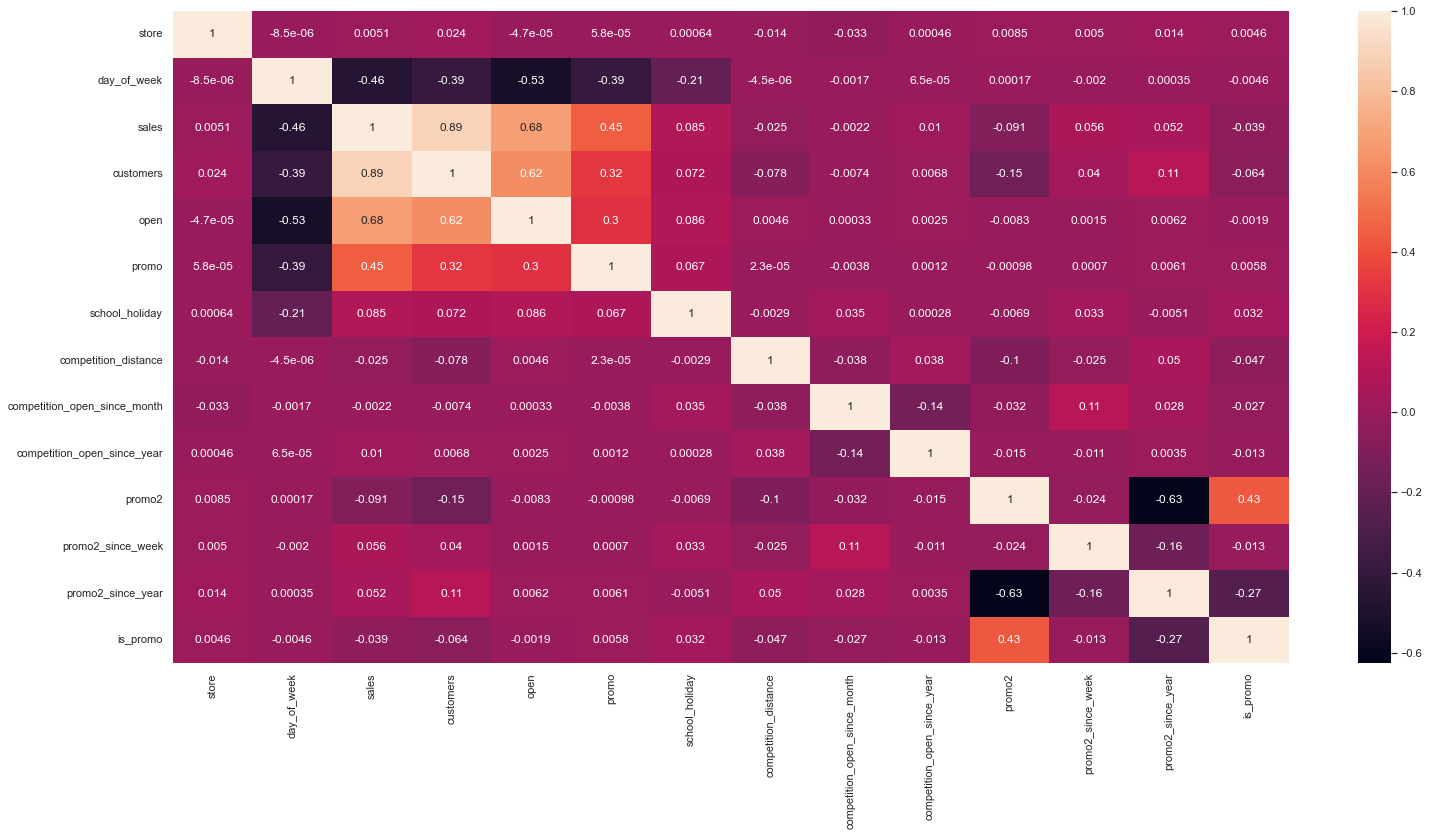

In [63]:
# cria uma tabela
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

### 4.3.2 Categorical Attributes

In [64]:
pip install PyCorr

Note: you may need to restart the kernel to use updated packages.


In [65]:
from scipy import stats as ss

from pycorrcat.pycorrcat import plot_corr, corr_matrix

In [66]:
#utilizando PyCorr
corr_matrix(a, ['state_holiday','store_type'])

,state_holiday,store_type
state_holiday,1.000000,0.231318
store_type,0.231318,1.000000


In [67]:
# variáveis categóricas originais
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [68]:
# vamos usar as 3 colunas daqui com as variáveis categóricas (year week é date)
a = df4.select_dtypes( include = 'object')
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


#### Calculo do V de Cramer - Varia de 0 a 1

v = np.sqrt( (chi2/n) / (min ( k -1, r-1)))

#### Matriz de confusão ou tabela de contigência: todas as combinações entre as variáveis  categóricas passadas e conta o número de linhas das combinações

In [69]:
pd.crosstab ( a['state_holiday'], a['store_type'])

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [70]:
#cm = confusion matrix
# .values: pega somente os numeros do dataframe
cm = pd.crosstab ( a['state_holiday'], a['store_type']).values

In [71]:
chi2 = ss.chi2_contingency( cm )

In [72]:
# 4 valores: resultado do teste, P valor, graus de liberdade e tabela de frequência
chi2

(12792.159524019908,
 0.0,
 9,
 array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
        [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
        [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
        [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

In [73]:
chi2[0]

n = cm.sum()

r, k = cm.shape

In [74]:
v = np.sqrt( (chi2[0]/n) / min(k- 1, r - 1)   )

In [75]:
v 

0.07106457093267678

In [76]:
# definindo uma função para calcular o valor do v de cramer
def cramer_v( x, y ):
  cm = pd.crosstab( x, y ).to_numpy()
  n = cm.sum()
  r, k = cm.shape

  chi2 = ss.chi2_contingency( cm )[0]
  chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )

  kcorr = k - (k-1)**2/(n-1)
  rcorr = r - (r-1)**2/(n-1)
  return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [77]:
cramer_v(a['state_holiday'], a['store_type'])

0.07106469715258833

<AxesSubplot:>

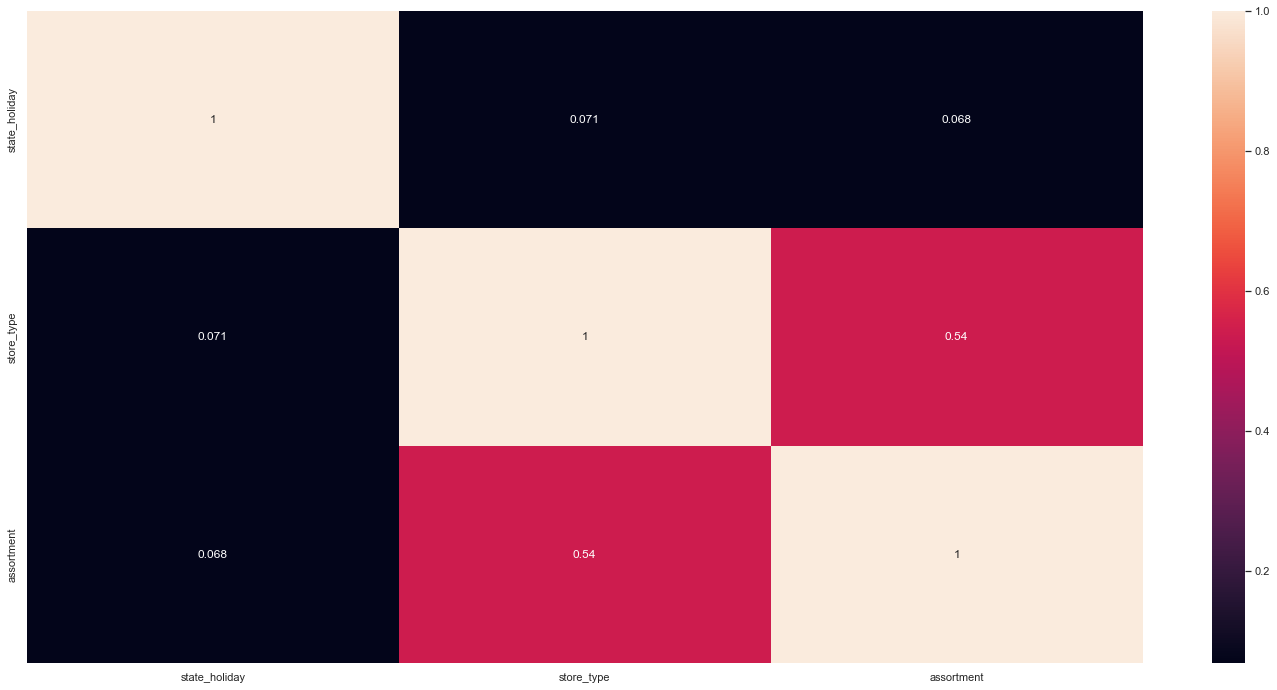

In [78]:
# Calculate cramer V - varia de 0 a 1

a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                   'store_type': [a4, a5, a6],
                   'assortment': [a7, a8, a9] }
                )

d = d.set_index( d.columns )
sns.heatmap( d, annot=True )

# 5.0 Data Preparation

## 5.0.0 Explicação Teórica

- O aprendizado da maioria dos algoritmos de ML é facilitado com
dados numéricos, na mesma escala.
- Tipos de preparação de dados: Normalização, Rescaling e Transformação.
- Encoding: transformar variáveis categóricas para numéricas.

In [79]:
df5 = df4.copy()
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Normalização

Como não temos nenhuma variável que tenha comportamento de uma normal, não vamos normalizar nada.

## 5.2 Rescaling

In [80]:
# pegando somente as variáveis numéricas
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


### Se a feature tiver outliers muito destacados, utilizo o RobustScaler

D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


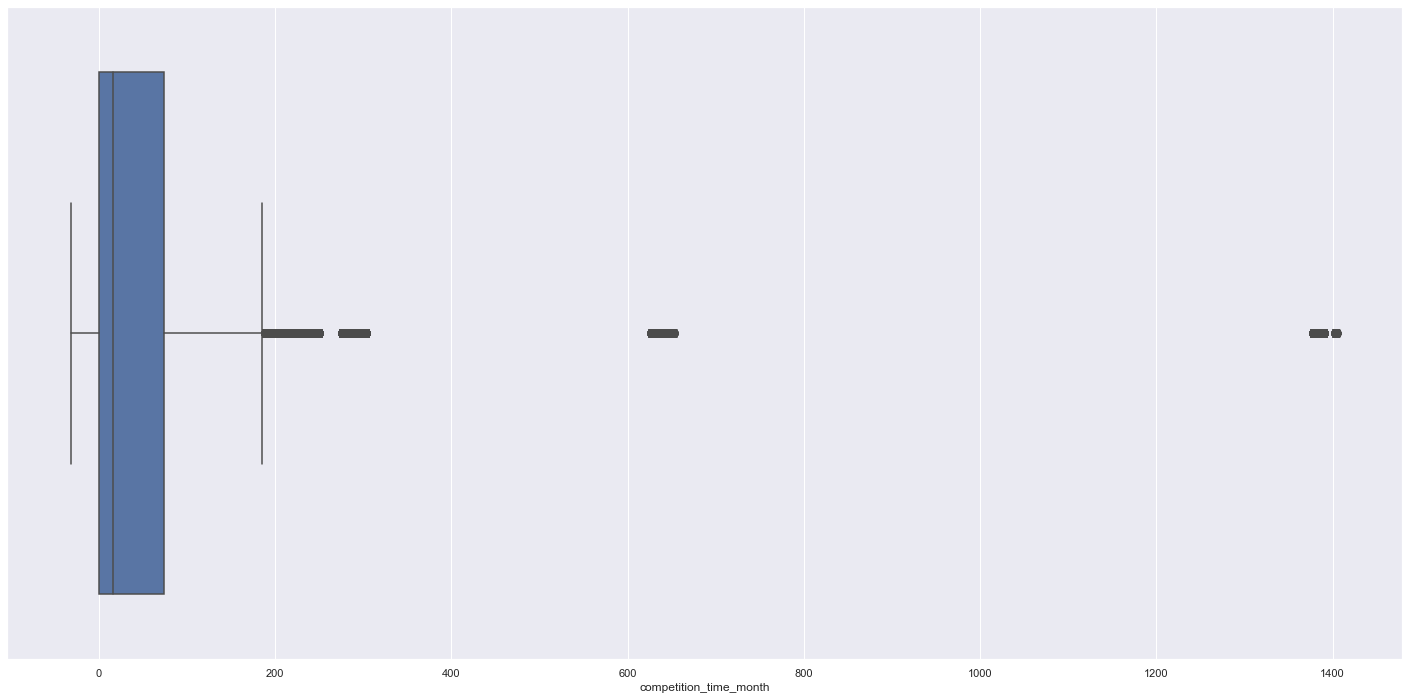

In [81]:
# verificação da competition_distance para ver se tem outliers:
sns.boxplot(df5['competition_time_month']);

In [82]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [83]:
rs = RobustScaler() #quando a feature tem muitos outliers
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open('parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump( rs, open('parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( mms, open('parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open('parameter/year_scaler.pkl', 'wb') )


In [84]:
df5[['competition_distance']].values

array([[-0.17096774],
       [-0.28387097],
       [ 1.90322581],
       ...,
       [-0.24032258],
       [-0.14516129],
       [-0.25967742]])

D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

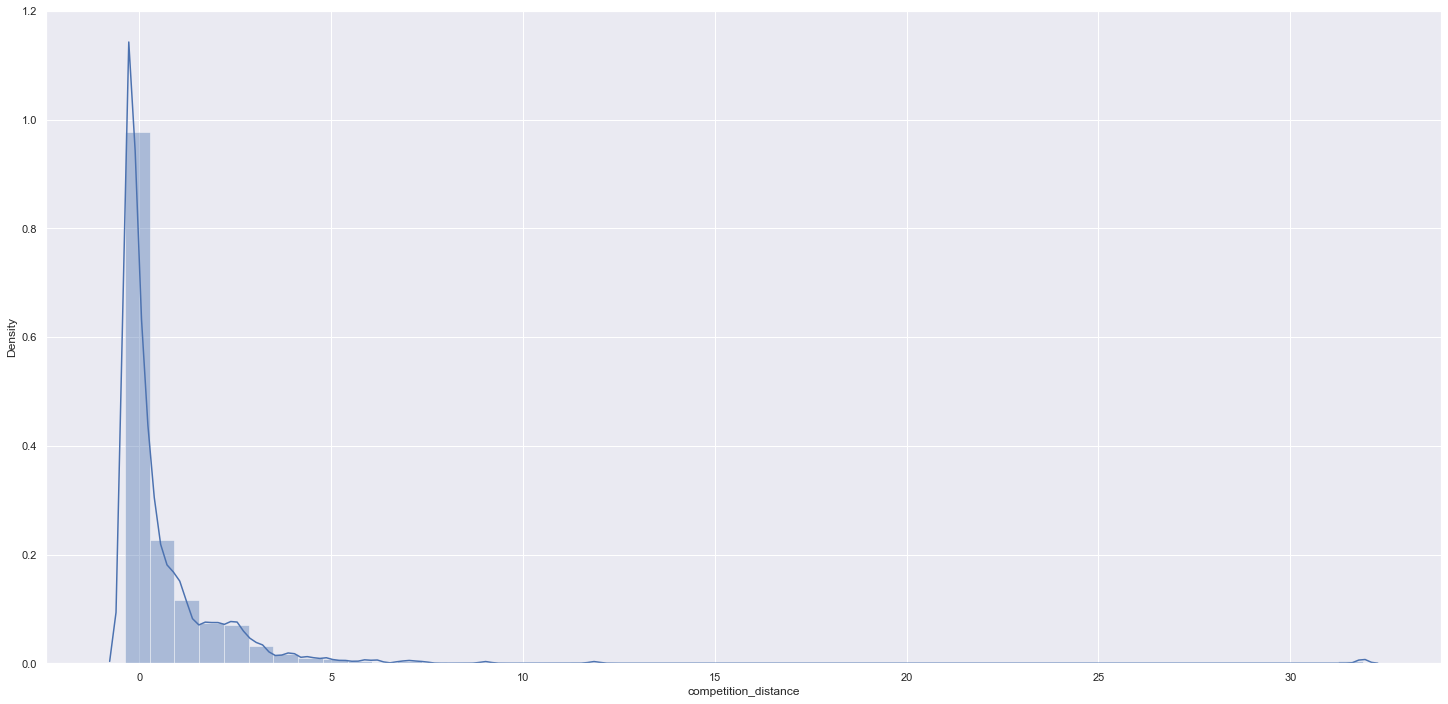

In [85]:
#competition distance com a nova escala.
sns.distplot(df5['competition_distance'])

## 5.3 Transformation

### Tipos de Encoding:
- One Hot Encoding: [1,0,0] [0,1,0] [0,0,1] 
- Label Encoding: troca os tipos das variáveis categóricas por números
    - funciona bem quando se tem variáveis que são apenas nomes
- Ordinal Encoding: warm, hot, very hot -> 1,2,3
- Target Encoding
- Frequency Encoding
- Embedding Encoding

### 5.3.1 Encoding


In [86]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


Variáveis categóricas a serem trabalhadas: state_holiday, store_type, assortment

In [87]:
#state_holiday - one hot encoding
## get_dummies: tira a coluna coluna principal e adiciona uma coluna diferente referente a cada feature que tinha na coluna
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

In [88]:
#coluna state_holiday já quebrada em outras colunas
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


In [89]:
#store_type - label encoding
le = LabelEncoder() #trocou as letras por números
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump( le, open('parameter/store_type_scaler.pkl', 'wb')  )

In [90]:
#assortment - ordinal encoding
df5['assortment'].astype(object)

assortment_dict = {'basic': 1,
                  'extra': 2,
                  'extended': 3
                   }
 
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [91]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


Transformação de grandeza: tras a variável resposta o mais próximo possível para uma normal

Transformação de natureza: trazer a natureza real dos seus dados para o conjunto de dados.

Os algoritmos de machine learning foram desenvolvidos para trabalhar com dados que seguem uma normal, portanto quanto mais próximo eles estiverem dessa curva, melhor sera a acuracia.

Tipos de transformações:

Transformações logaritmicas: pegam uma skew e jogam de volta para uma normal
Box-Cox Trasnformation
Cube-Root Transformation 
Square root transformation
Sine and Cosine transformation

### 5.3.2 Response Variable Transformation

In [92]:
# sai de uma transformação parecida com uma poisson e vira uma normal
# a ser aplicado na variável resposta
df5['sales'] = np.log1p(df5['sales'])


D:\Anaconda\envs\ds_em_producao\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

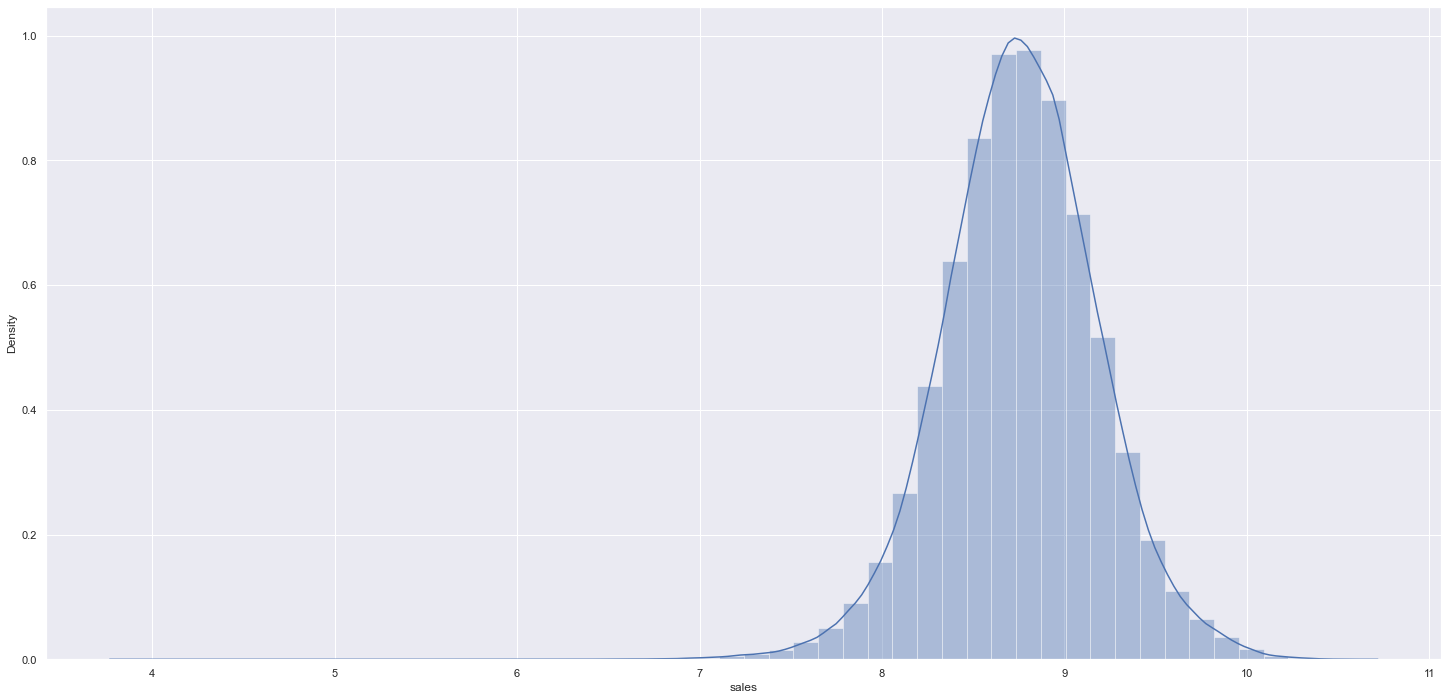

In [93]:
sns.distplot(df5['sales'])

### 5.3.2 Nature Transformation

In [94]:
# variáveis cíclicas:

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi / 30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi / 52)))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi / 7)))

In [95]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 Featuring Selection

## 6.0.0 Explicação teórica

Principio de Occam's Razor: se eu tenho 2 modelos que representam a mesma coisa,
ficar com o mais simples.

Quando 2 ou mais variáveis explicam a mesma coisa, chamamos as variáveis de colineares.

Tipos de seleção de variáveis: 

- Seleção univariada (Filter Methods): critério: correlação. coeficiente de correlação, intensidade da relação entre 2 variáveis.
    - Vantagens: simples, rápido e de fácil entendimento.
    - Desvantagem: não considera a influência entre as variáveis.
    
    
- Seleção por importância (Embedded Methods)
    - Random Forest: 
    - Lasso Regression
    - Ridge Regression
    

- Seleção por subset (Wrapper Methods)
    - Algoritmo Boruta: 

In [96]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [97]:
# preciso deletar todas as variáveis que deram origem a outras diferentes
cols_drop = ['month', 'day', 'week_of_year', 'day_of_week', 'promo_since',
                 'competition_since', 'year_week' ]
df6 = df6.drop(cols_drop, axis = 1)


In [98]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [99]:
df6[['store', 'date']].groupby('store').max().reset_index

<bound method DataFrame.reset_index of             date
store           
1     2015-07-31
2     2015-07-31
3     2015-07-31
4     2015-07-31
5     2015-07-31
6     2015-07-31
7     2015-07-31
8     2015-07-31
9     2015-07-31
10    2015-07-31
11    2015-07-31
12    2015-07-31
13    2015-07-31
14    2015-07-31
15    2015-07-31
16    2015-07-31
17    2015-07-31
18    2015-07-31
19    2015-07-31
20    2015-07-31
21    2015-07-31
22    2015-07-31
23    2015-07-31
24    2015-07-31
25    2015-07-31
26    2015-07-31
27    2015-07-31
28    2015-07-31
29    2015-07-31
30    2015-07-31
31    2015-07-31
32    2015-07-31
33    2015-07-31
34    2015-07-31
35    2015-07-31
36    2015-07-31
37    2015-07-31
38    2015-07-31
39    2015-07-31
40    2015-07-31
41    2015-07-31
42    2015-07-31
43    2015-07-31
44    2015-07-31
45    2015-07-31
46    2015-07-31
47    2015-07-31
48    2015-07-31
49    2015-07-31
50    2015-07-31
51    2015-07-31
52    2015-07-31
53    2015-07-31
54    2015-07-31
55    201

In [100]:
# date min: 2013-01-02
# date max: 2015-07-31

In [101]:
# data da semana mais alta menos 6 semanas
pd.to_datetime('2015-07-31') - datetime.timedelta(days = 42)

Timestamp('2015-06-19 00:00:00')

In [102]:
#filtro do dataframe para datas menos que 2015-06-19 
x_train = df6[df6['date'] < '2015-06-19']

y_train = x_train['sales']

#test dataset
x_test = df6[df6['date'] >= '2015-06-19']

y_test = x_test['sales']

## 6.2 Boruta as feature selector

The two snipets above was commented because we dont need to run them again.

In [103]:
## training and test dataset
#x_train_n = x_train.drop(['sales', 'date'], axis = 1).values
#y_train_n = y_train.values.ravel()

##define randomforest
#rf = RandomForestRegressor (n_jobs = -1)

##define boruta
##confirmed: quantas variáveis ele já avaliou como importante pro modelo #tentative: variáveis que ele teve duvida 
#boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(x_train_n, y_train_n)

## 6.2.1 Best Features from Boruta

In [104]:
## pega o array gerado e coloca em forma de lista
#cols_selected = boruta.support_.tolist()

##melhores features
#x_train_fs = x_train.drop(['sales', 'date'], axis = 1)
#cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.tolist()

##colunas não selecionadas
#cols_not_selected_boruta = np.setdiff1d(x_train_fs.columns, cols_selected_boruta).tolist()

## 6.2.1 Manual Feature Selection

In [105]:
#boruta não selecionou month_sin e week_of_year_sin, mas será adicionado manualmente
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin', #adicionada manualmente
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin', #adicionada manualmente
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos']


In [106]:
# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()

cols_selected_boruta_full.extend( feat_to_add )
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# 7.0  Machine Learning Modelling

## 7.0.1 - Preparation/Info's

- Aprendizado Supervisionado
    - Classificação
    - Regressão
    - Séries Temporais
    
    
- Aprendizado Não Supervisionado
    - Agrupamento/Clusterização
    
    
- Aprendizado Semi-Supervisionado
    - Reinforcement Learning

In [107]:
df7 = df6.copy()

In [108]:
# voltei na columns to add e retirei sales e date

In [109]:
# criação das variáveis x de treino e teste com as features importantes
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

x_training = x_train[cols_selected_boruta_full]

## 7.1 Average Model

In [110]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['sales','store']].groupby('store').mean().reset_index().rename(columns= {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how = 'left', on = 'store')
yhat_baseline = aux1['predictions']

#performance
## tenho que retornar os testes ao normal depois do data preparation: (np.expm1)
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [111]:
#model
lr = LinearRegression().fit(X_train, y_train)

#prediction
yhat_lr = lr.predict(X_test)

#performance
lr_result = ml_error('Linear Regression Model', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Model,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [112]:
xtraining = x_train[cols_selected_boruta_full]

In [113]:
lr_result_cv = cross_validation(xtraining, 5,'Linear Regression', lr, verbose= False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [114]:
#model
lrr = Lasso(alpha = 0.01).fit(X_train, y_train)

#prediction
yhat_lrr = lrr.predict(X_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Linear Regression Model Lasso - Cross Validation

In [115]:
lrr_result_cv = cross_validation(xtraining, 5,'Linear Regression - Lasso', lrr, verbose= False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [116]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(X_train, y_train)

#prediction
yhat_rf = rf.predict(X_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837


### 7.4.1 Random Forest Regressor - Cross Validation

In [117]:
rf_result_cv = cross_validation(xtraining, 5,'Random Forest Regressor', rf, verbose= True)
rf_result_cv


KFoldNumber: 5

KFoldNumber: 4

KFoldNumber: 3

KFoldNumber: 2

KFoldNumber: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73


## 7.5 XGBoost Regressor

In [118]:
X_train[['store_type', 'assortment']].astype("category").head()

,store_type,assortment
47945,2,1
47946,0,1
47947,0,1
47948,2,3
47949,0,1


In [119]:
#model
model_xgb = xgb.XGBRegressor().fit( X_train, y_train )

#prediction
yhat_xgb = model_xgb.predict(X_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

D:\Anaconda\envs\ds_em_producao\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,868.958205,0.130309,1238.550843


### 7.5.1 XGBoost Regressor - Cross Validation

In [120]:
xgb_result_cv = cross_validation(xtraining, 5,'XGBoost Regressor', model_xgb, verbose= True)
xgb_result_cv


KFoldNumber: 5


D:\Anaconda\envs\ds_em_producao\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFoldNumber: 4


D:\Anaconda\envs\ds_em_producao\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFoldNumber: 3


D:\Anaconda\envs\ds_em_producao\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFoldNumber: 2


D:\Anaconda\envs\ds_em_producao\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



KFoldNumber: 1


D:\Anaconda\envs\ds_em_producao\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1077.35 +/- 201.87,0.15 +/- 0.02,1542.86 +/- 280.54


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [121]:
#tabela de comparação dos resultados dos erros dos modelos
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result, xgb_result ])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.687799,0.099937,1010.607837
0,XGBoost Regressor,868.958205,0.130309,1238.550843
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression Model,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


### 7.6.2 Real Performance - Cross Validation

- Para o Cross-Validation, nós separamos as variáveis de treino, em treino e 'validação', para não misturar com as variáveis de 'teste', que já estão separadas das de treino e validação.

- Temos um tipo de Cross-Validation para Classificação e Regressão, e outro para Time-Series.
    - Times-Series: preciso manter a ordem cronológica dos dados.

In [122]:
#tabela de comparação dos resultados dos erros dos modelos
modelling_result_cv = pd.concat([lr_result_cv,lrr_result_cv,rf_result_cv, xgb_result_cv ])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.97 +/- 218.4,0.12 +/- 0.02,1256.45 +/- 318.73
0,XGBoost Regressor,1077.35 +/- 201.87,0.15 +/- 0.02,1542.86 +/- 280.54
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


In [123]:
#pegando os dados de treino somente com as colunas importantes e com a date e sales
x_training = x_train[cols_selected_boruta_full]
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,0.891892,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,1.027027,0.908884,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,1.189189,0.788155,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,0.729730,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,-0.189189,0.287016,1.224647e-16,-1.0,-0.587785,-0.809017,0.120537,-0.992709,-0.433884,-0.900969,2015-06-18,8.502080


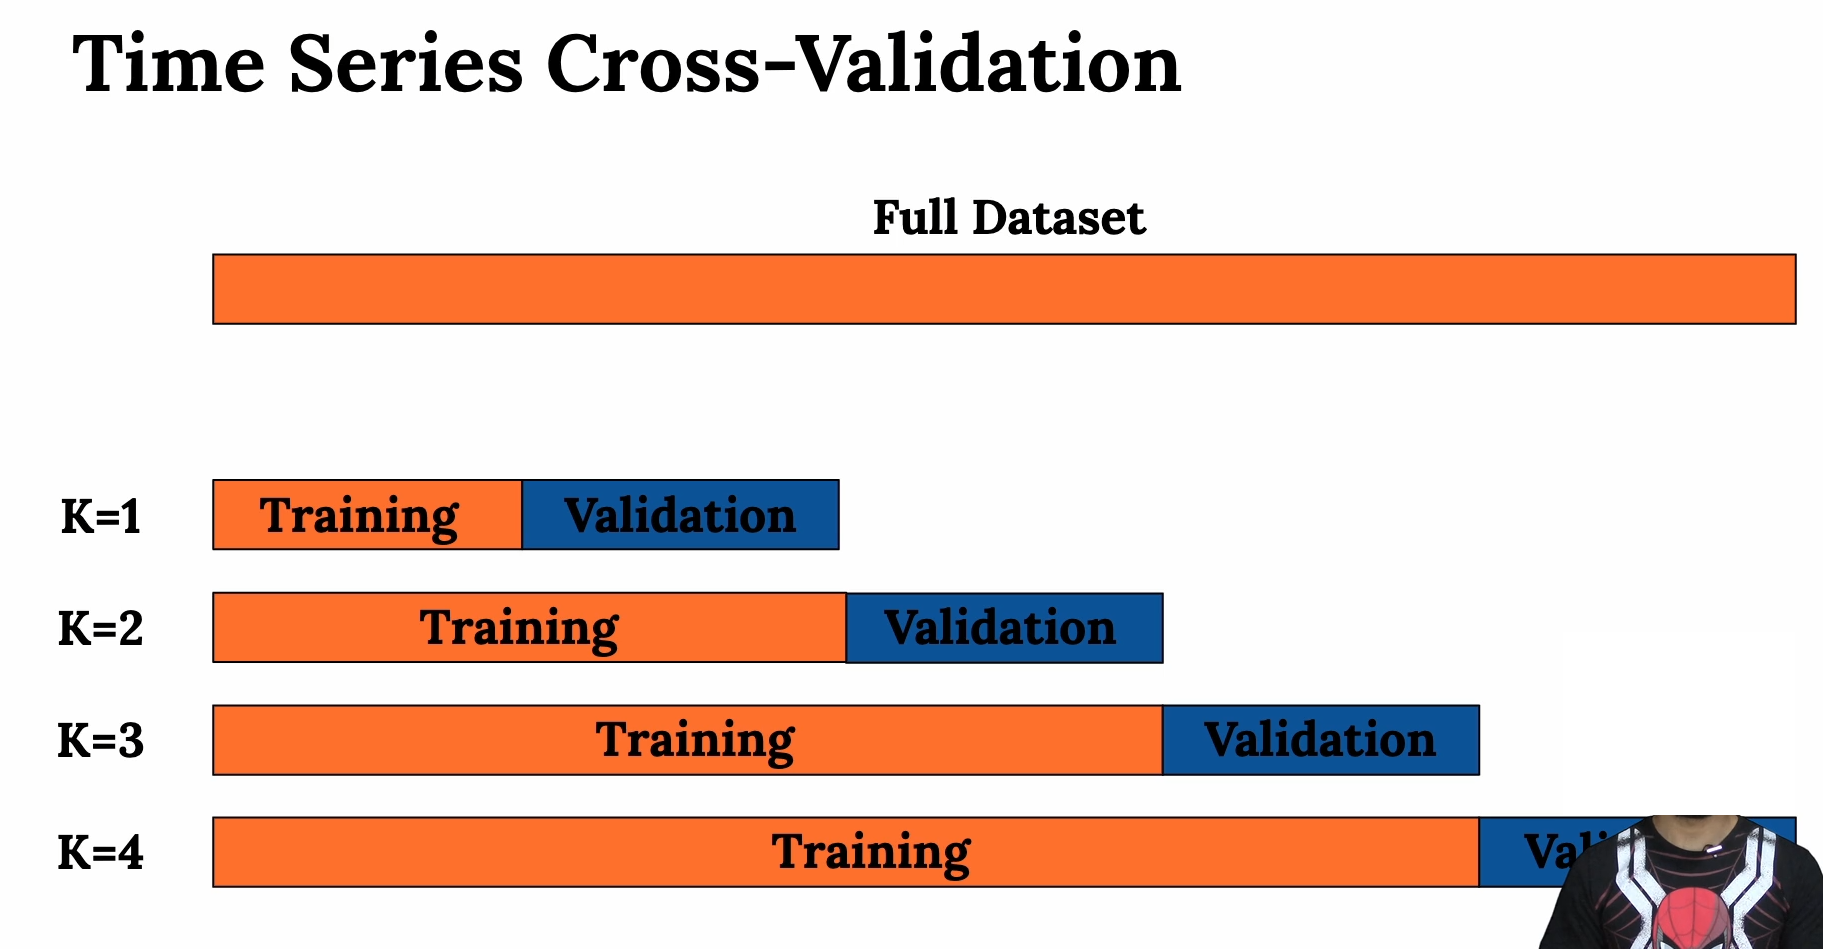

In [124]:
Image('time_series_cross_validation.png')

In [125]:
xtraining = x_train[cols_selected_boruta_full]

In [126]:
cross_validation( xtraining, 5, 'Linear Regression', lrr, verbose = True )


KFoldNumber: 5

KFoldNumber: 4

KFoldNumber: 3

KFoldNumber: 2

KFoldNumber: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0 Hyperparameter Fine Tuning

## 8.0.0 Explicações teóricas

3 estratégias de fine tuning:

    - Random Search:
        - Define valores aleatórios para os hiperparâmetro aleatoriamente
        - Vantagens: rápido e baixo custo
        
    - Grid Search: 
        - Define todas as combinações possíveis que hiperparâmetros podem assumir
        - Vantagens: consegue achar a melhor combinação, ou muito perto
        - Desvantagem: demora demais
        
    - Bayesian Search: 
        - Define os valores dos hiperparâmetros seguindo a teoria de Bayes

## 8.1 Random Search

In [127]:
import random
import warnings
warnings.filterwarnings('ignore')

In [128]:
##dicionario chave:valor para os hiperparametros
#param = {
#        'n_estimators': [15, 17, 25, 30, 35],
#        'eta': [0.01, 0.03],
#        'max_depth': [3, 5, 9],
#        'subsample': [0.1, 0.5, 0.7],
#        'colsample_bytree': [0.3, 0.7, 0.9],
#        'min_child_weight': [3, 8, 15],    
    
    
#}

## número de erros que iremos colocar no dataframe
#MAX_EVAL = 5

In [129]:
##aonde ficam guardados os reultados das iterações
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
#    # choose values parameters randomly
#    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#    print(hp)
    
#    #model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                n_estimators=hp['n_estimators'],
#                                eta=hp['eta'],
#                                max_depth=hp['max_depth'],
#                                subsample=hp['subsample'],
#                                colsample_bytee=hp['colsample_bytree'],
#                                min_child_weight= hp['min_child_weight'])#.fit( X_train, y_train ) treinamento embutido dentro do cross validation


#    #performance
#    result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb ) 
#    final_result = pd.concat([final_result, result])
    
#final_result     

## 8.2 Final Mode 

In [130]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3   
    
    
}


In [131]:
    #model
    model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                n_estimators=param_tuned['n_estimators'],
                                eta=param_tuned['eta'],
                                max_depth=param_tuned['max_depth'],
                                subsample=param_tuned['subsample'],
                                colsample_bytree=param_tuned['colsample_bytree'],
                                min_child_weight= param_tuned['min_child_weight']).fit( X_train, y_train ) 

    #prediction
    yhat_xgb_tuned = model_xgb_tuned.predict(X_test)
    
    #performance
    xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
    xgb_result_tuned
    
 

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,773.436567,0.116557,1105.32702


# 9.0 Interpretação e Tradução do Erro

In [132]:
df9 = x_test[cols_selected_boruta_full]

#rescale: dados de predição estão em escala logaritmica
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned )

## 9.0.0 Explicações teóricas

Erro MAE (Mean squared Error):

    - Atribui peso igual para todos os erros 
    - Robusto na presença de outliers
    - Fácil entendimento pelo time de negócio

ERRO MAPE

    - Mostra o quão longe a predição está do valor real, na média, em porcentagem
    - Muito usado na divulgação de resultados
    - Não pode ser usado se a variável resposta contém 0

ERRO RMSE (Root Mean squared Error)

    - Atribui MAIOR PESO a erros MAIORES(outliers)    
    - Sensível na presença de Outliers    
    - Ideal para medir a performance de Modelos ML

ERRO MPE: Não faz parte da interpretação da performannce real do modelo

    - Não pode ser usado para medir performance do modelo
    - Útil para saber se o seu modelo esta subestimando ou superestimando o resultado
    - Não pode ser usado se a variável resposta contém 0

Como utilizar os erros para mostrar o valor em real para o negócio

Performance do Modelo sobre o negócio:
 
    - Comparação com o status quo
    - Incremento de receita

## 9.1 Business Performance

In [133]:
#sum of predictions: pra saber quanto de dinheiro vai entrar
## pegamos 'store' e 'predictions' porque o cfo quer saber as predições com relação as lojas
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] )).reset_index().rename( columns= {0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] )).reset_index().rename( columns= {0:'MAPE'})

#Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how = 'inner', on = 'store' )
df92 = pd.merge ( df91, df9_aux3, how = 'inner', on = 'store')

#scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario']  = df92['predictions'] + df92['MAE']

#order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]

In [134]:
df92.sort_values('MAPE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107841.484375,104476.965512,111206.003238,3364.518863,0.591882
908,909,218781.015625,210826.171981,226735.859269,7954.843644,0.519696
901,902,204006.656250,202490.476153,205522.836347,1516.180097,0.379608
169,170,206122.453125,204658.386785,207586.519465,1464.066340,0.361991
875,876,201956.593750,198003.428191,205909.759309,3953.165559,0.325685


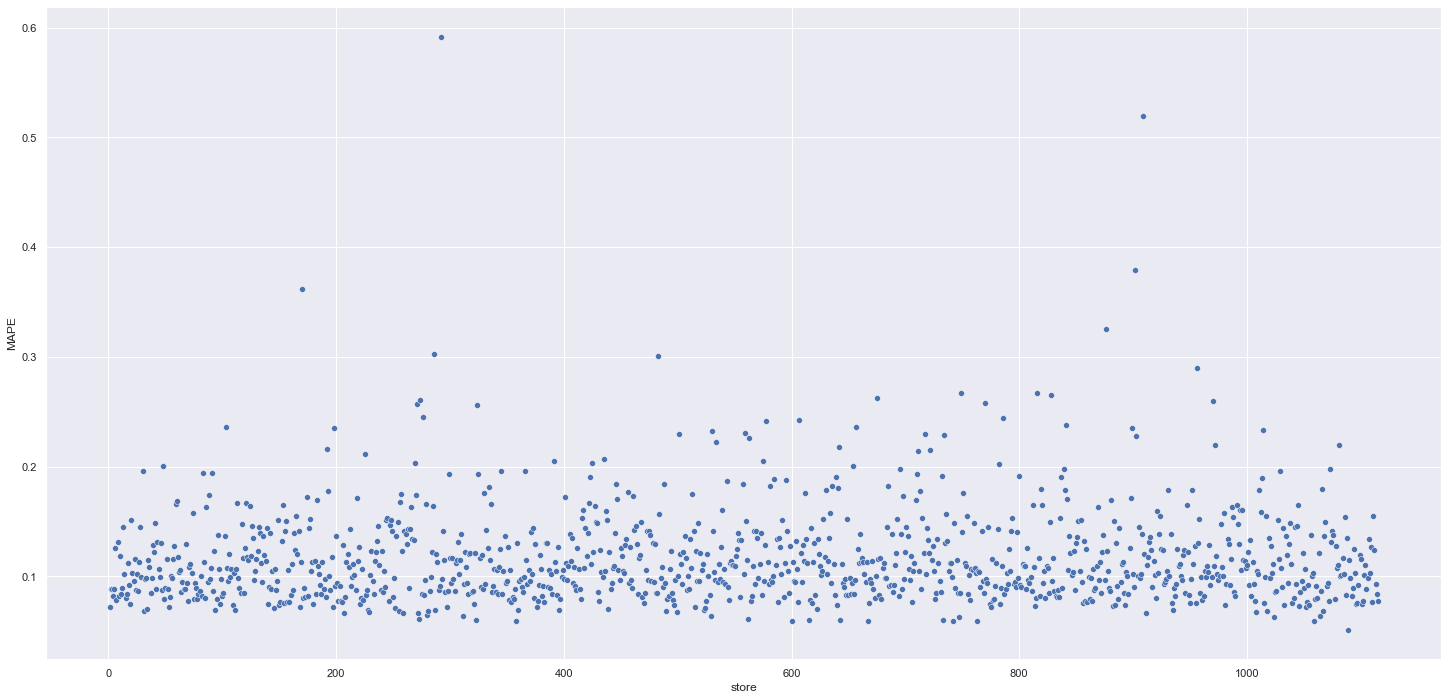

In [135]:
#visualizando graficamente quais as lojas tem os maiores e menores MAPE
sns.scatterplot( x = 'store', y = "MAPE", data = df92 );

## 9.2 Total Performance

In [136]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns = {'index': 'Scenario',
                                                                                                                             0:'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$ 286,675,456.00"
1,worst_scenario,"R$ 285,809,942.91"
2,best_scenario,"R$ 287,540,984.78"


## 9.3 Machine Learning Performance

In [137]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

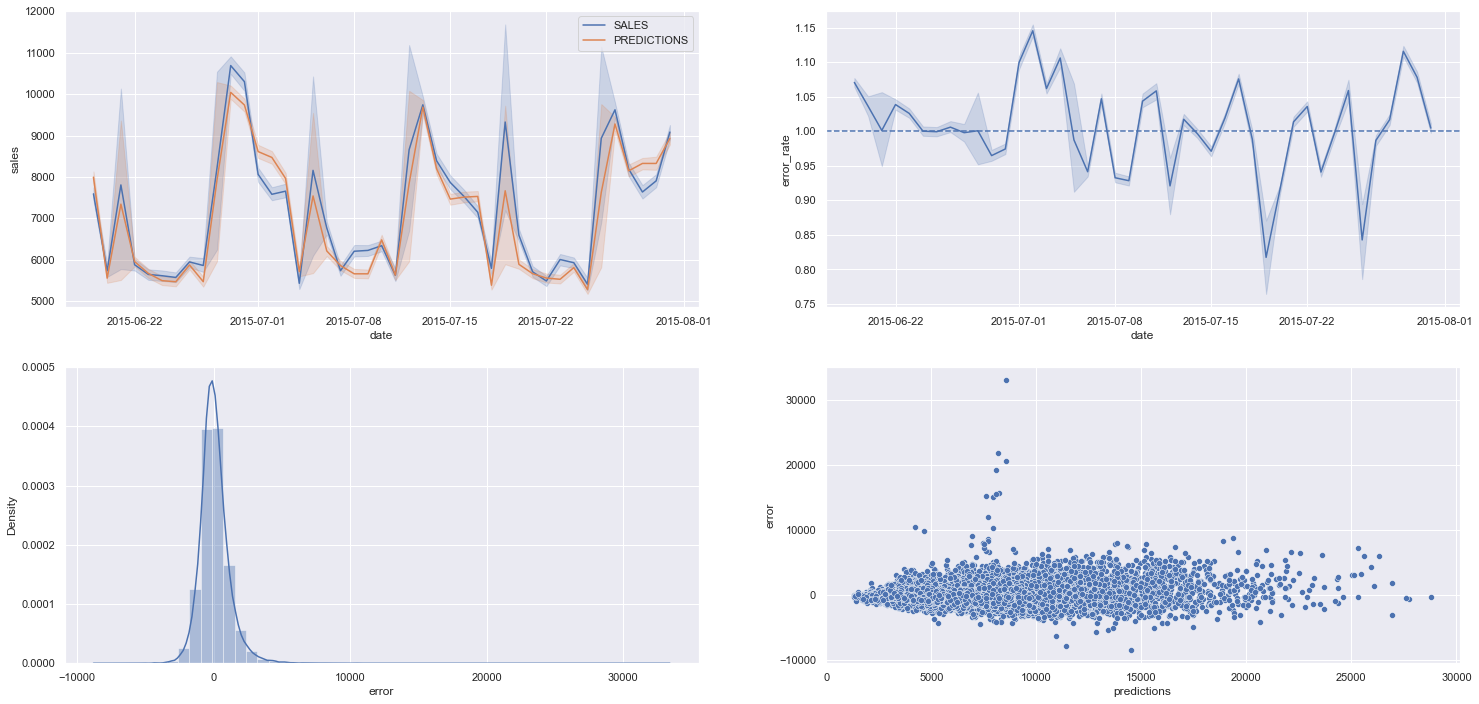

In [138]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )


In [139]:
pickle.dump( model_xgb_tuned, open(r'C:\Users\Will\repos\comunidadeds\ds_em_producao.pkl', 'wb'))

# 10.0 Deploy Model to Production

## 10.0.0 Explicação teórica

Arquitetura de produção: 
   
        App, Dashboard, Website -> Handler API [ <-> Data Preparation, <- Model Trained ]

Lista de tarefas

    1 - Criar uma classe com as Limpezas, transformações e Encoding
    ( Rossmann.py)
    
    2 -Criar a API (Handler.py)
    
    3 - Criar um script para testar a API

## 10.1 Rossmann Class

In [154]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    
    def __init__( self ):
        self.home_path ='C:Will/repos/comunidadeds/ds_em_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
    def data_cleaning( self, df1 ):
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday',
        'StoreType', 'Assortment', 'CompetitionDistance','CompetitionOpenSinceMonth',
        'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']
        
        snakecase = lambda x: inflection.underscore( x )
        
        cols_new = list( map( snakecase, cols_old ) )
        
        # rename
        df1.columns = cols_new
        
        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )
        
        ## 1.5. Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )
        
        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                        if math.isnan( x['competition_open_since_month'] ) 
                                                        else x['competition_open_since_month'], axis=1 )
                                 
            #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                                       if math.isnan( x['competition_open_since_year'] ) 
                                                       else x['competition_open_since_year'], axis=1 )
        
        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week 
                                             if math.isnan( x['promo2_since_week'] )
                                             else x['promo2_since_week'], axis=1 )
        
        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year 
                                             if math.isnan( x['promo2_since_year'] )
                                             else x['promo2_since_year'], axis=1 )
        
        #promo_interval
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6:'Jun',
                     7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        
        df1['promo_interval'].fillna( 0, inplace=True )
        df1['month_map'] = df1['date'].dt.month.map( month_map )
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0
                                                                                 if x['promo_interval'] == 0
                                                                     else 1 if x['month_map'] in x['promo_interval'].split( ',' )
                                                                     else 0, axis=1 )
        
        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year']  = df1['competition_open_since_year'].astype( int )
        
        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1
    
    def feature_engineering( self, df2 ):
        # year
        df2['year'] = df2['date'].dt.year
        
        # month
        df2['month'] = df2['date'].dt.month
        
        # day
        df2['day'] = df2['date'].dt.day
        
        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )
        
        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'],
        month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )
        
        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        
        df2['promo_since'] = df2['promo_since'].apply( lambda x: 
                                datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )
        
        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x ==
        'a' else 'extra' if x == 'b' else 'extended' )
        
        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x:'public_holiday' 
                                                          if x == 'a' else 'easter_holiday' if x == 'b' 
                                                          else 'christmas' if x == 'c' else 'regular_day' )
        
        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]
        
        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2
    
    def data_preparation( self, df5 ):
        ## 5.2. Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
        
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
        
        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )
        
        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )
        
        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'] )
        
        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )
        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi / 7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi / 7 ) ) )
        
        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi / 12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi / 12 ) ) )
        
        # day
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi / 30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi / 30 ) ) )
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi / 52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi / 52 ) ) )
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment',
                         'competition_distance', 'competition_open_since_month',                    
                         'competition_open_since_year', 'promo2', 'promo2_since_week','promo2_since_year',
                         'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos',
                         'month_sin', 'month_cos','day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2 API Handler

Arquivo que passa as infos requisitadas para as aplicações corretas.

In [153]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann #import: é o nome da classe

#loading model
model = pickle.load( open('C:/Users/Will/repos/comunidadeds/ds_em_producao/model/model_rossmann.pkl', 'rb') ) 

# inicializando a API
app = Flask (__name__)

#definição do endpoint
#toda vez que ele receber uma chamada via post, ele executa a primeira função embaixo dele
@app.route('/rossmann/predict', methods = ['POST'] ) # POST: envia algum dado depois de receber, não fica pedindo


def rossmann_predict():
    test_json = request.get_json()   #pega o json que vai ser enviado via API
    
    # if para a verificação se o dado chegou mesmo
    if test_json:
        if isinstance( test_json, dict ): #se for 1 linha de .json:
            test_raw = pd.DataFrame(test_json, index = [0]) 
        else: #se vierem varios .json concatenados
            test_raw = pd.DataFrame(test_json, columns = test_json[0].keys() )
            
        #Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
    
    
        
    else:
        return Response( '{}', status = 200, mimetype = 'application/json' )
    
    
    -
if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Tester

In [142]:
#loading test dataset
df10 = pd.read_csv('test.csv')
df10.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [145]:
# merge test dataset + store
df_test = pd.merge ( df10, df_store_raw, how = 'left', on = 'Store' ) 

#choose store for prediction
df_test = df_test[df_test['Store'] == 22 ]

#remove closed days
df_test = df_test[df_test['Open'] != 0 ]
df_test = df_test[~df_test['Open'].isnull() ]
df_test = df_test.drop('Id', axis = 1)

In [147]:
#convert dataframe to .json
data = json.dumps( df_test.to_dict( orient = 'records') )

In [148]:
data

'[{"Store": 22, "DayOfWeek": 4, "Date": "2015-09-17", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 3, "Date": "2015-09-16", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.0, "Promo2SinceYear": 2012.0, "PromoInterval": "Jan,Apr,Jul,Oct"}, {"Store": 22, "DayOfWeek": 2, "Date": "2015-09-15", "Open": 1.0, "Promo": 1, "StateHoliday": "0", "SchoolHoliday": 0, "StoreType": "a", "Assortment": "a", "CompetitionDistance": 1040.0, "CompetitionOpenSinceMonth": NaN, "CompetitionOpenSinceYear": NaN, "Promo2": 1, "Promo2SinceWeek": 22.

In [150]:
#API Call
url    = 'http://0.0.0.0:5000/rossmann/predict' 
header = {'Content-type': 'application/json'}   #tipo de requisição
data   = data

r = request.post( url, data = data, headers = header)
print('Status Code {}'.format( r.status_code ))

RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request.  Consult the documentation on testing for
information about how to avoid this problem.